# Introducción

En este entregable final se presenta el desarrollo completo de una solución de clasificación de texto orientada al análisis de comentarios en lenguaje natural, abarcando desde enfoques clásicos de Machine Learning hasta modelos modernos basados en Deep Learning y Transformers. El objetivo principal fue construir y comparar distintos modelos capaces de identificar patrones semánticos y lingüísticos en texto, evaluando su desempeño, robustez y viabilidad de despliegue en un entorno productivo.

Para lograrlo, se implementaron y analizaron cinco enfoques principales: Árbol de Decisión, Naive Bayes, TF-IDF + Regresión Logística, BETO y RoBERTa. Cada modelo representa un nivel distinto de complejidad y capacidad de representación del lenguaje, permitiendo contrastar alternativas en términos de precisión, interpretabilidad, costo computacional y adaptabilidad a distintos tipos de datos.

## Librerías necesarias

In [2]:
# ============================================================
# Librerías base + modelado + métricas
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from textwrap import wrap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import(
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    balanced_accuracy_score
)

from scipy.stats import loguniform
from scipy.sparse import hstack
import joblib
import re
import seaborn as sns
from datasets import Dataset

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stopwords_pt = stopwords.words("portuguese")

from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# ============================================================
# 1. Carga del dataset consolidado
# ============================================================
# Se utiliza el archivo final (completo) ya preparado para el pipeline
# de limpieza, feature engineering y entrenamiento de modelos.
# Nota: asegúrate de que `df_completo_fx.csv` contenga la ruta correcta al CSV.
df = pd.read_csv("df_completo_fx.csv")

# Validación mínima (forma y primeras filas)
print("Dataset cargado:", df.shape)
df.head(3)

Dataset cargado: (197037, 7)


,id,review_body,stars,language,lenght_review_body,review_body_clean,sentiment
0,0,"sí es totalmente impermeable, pero no se adapt...",3,es,144,sí es totalmente impermeable pero no se adapta...,neutro
1,1,el precio esta bien del producto pero el embal...,3,es,174,el precio esta bien del producto pero el embal...,neutro
2,2,De momento va muy bien y tiene un diseño muy e...,5,es,54,de momento va muy bien y tiene un diseño muy e...,positivo


# Proceso ETL

## A) Proceso ETL orientado a un modelo de Análisis de Sentimiento (Español)

### A.1) El Dataset
El DataSet utilizado para el proceso es un conjunto de datos (`0000.parquet`) de reseñas de productos
de Amazon en español, disponible en la plataforma Hugging Face para tareas de procesamiento de lenguaje natural como clasificación, generación de texto o análisis de sentimiento.

[DataSet](https://huggingface.co/datasets/KRadim/edit_amazon_reviews_multi_es)

Este dataset forma parte de una colección mayor conocida como Multilingual Amazon Reviews (corpus multilingüe de reseñas de Amazon), la cual fue desarrollada originalmente con datos balanceados de reseñas en múltiples idiomas y estrellas de evaluación para facilitar tareas de aprendizaje automático. Para nuestro caso, nos enfocaremos en la columna `"review_body"`.

### A.2) Contenido y estructura del dataset
El dataset incluye:
1) Reseñas en español
2) Campos principales por registro:
    - id: Identificador único de la reseña.
    - stars: Calificación numérica del producto (de 1 a 5 estrellas).
    - review_body: Texto completo de la reseña del producto.
    - review_title: Título o resumen corto de la reseña.
    - language: Código de idioma (en este caso siempre “es” para español).
    - product_category: Categoría o tipo de producto.
    - lenght_review_body: Longitud (número de caracteres) del cuerpo de la reseña.
    - lenght_review_title: Longitud del título.
    - lenght_product_category: Longitud del nombre de la categoría del producto.

### A.3) Extracción de archivos (Extract)


In [3]:
df = pd.read_parquet("0000.parquet")
df.head(3)


# ============================================================
# A.3.1) Validaciones iniciales
# ============================================================
df.info()
df.shape
df["lenght_review_body"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199500 entries, 0 to 199499
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       199500 non-null  uint32
 1   stars                    199500 non-null  int64 
 2   review_body              199500 non-null  object
 3   review_title             199500 non-null  object
 4   language                 199500 non-null  object
 5   product_category         199500 non-null  object
 6   lenght_review_body       199500 non-null  uint32
 7   lenght_review_title      199500 non-null  uint32
 8   lenght_product_category  199500 non-null  uint32
dtypes: int64(1), object(4), uint32(4)
memory usage: 10.7+ MB


,lenght_review_body
count,199500.000000
mean,151.289950
std,132.185062
min,16.000000
25%,68.000000
50%,120.000000
75%,186.000000
max,3086.000000



### A.4) Trasformación

Aquí se limpia, normaliza y estructura el texto para que el modelo pueda aprender patrones reales.

La transformación se divide en sub-etapas lógicas:
1) Selección de columnas relevantes
2) Eliminación de nulos
3) Normalización de idioma
4) Eliminación de comentarios duplicados
5) Limpieza de texto (Text Cleaning)
6) Creación de la etiqueta de sentimiento (Labeling)
7) Balanceo y validación de clases
8) Análisis estadístico para tomar un subconjunto de datos del DataSet (5000),para el entrenamiento del modelo.

In [5]:
# ============================================================
# A.4.1) Selección de columnas relevantes
# ============================================================
df = df[["id", "review_body", "stars", "language", "lenght_review_body"]]

In [6]:
# ============================================================
# A.4.2) Eliminación de elementos nulos
# ============================================================
df = df.dropna(subset=["review_body"])

In [7]:
# ============================================================
# A.4.3) Normalización de idioma
# ============================================================
df["language"] = df["language"].astype(str).str.lower().str[:2]
df = df[df["language"] == "es"]

In [8]:
# ============================================================
# A.4.4) Eliminación de comentarios duplicados
# ============================================================
df["review_body_clean"] = (
    df["review_body"]
    .astype(str)
    .str.lower()
    .str.strip()
)
df = df.drop_duplicates(subset=["review_body_clean"])
df.head(3)

,id,review_body,stars,language,lenght_review_body,review_body_clean
0,111516,No llegaron las hélices,1,es,23,no llegaron las hélices
1,107084,Me encanta lo ligera y manejable que es. Plega...,4,es,420,me encanta lo ligera y manejable que es. plega...
2,199386,"De las dos baterias , hay una que no funciona",1,es,45,"de las dos baterias , hay una que no funciona"


In [9]:
# ============================================================
# A.4.5) Limpieza de texto (Text Cleaning)
# ============================================================
df["review_body_clean"] = (
    df["review_body"]
    .astype(str)
    .str.lower()
    .str.replace(r"http\S+", "", regex=True)
    .str.replace(r"[^a-záéíóúñü\s]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df = df.drop_duplicates(subset=["review_body_clean"])

In [10]:
# ============================================================
# A.4.5.a) Control de vacíos tras limpieza
# ============================================================
df = df[df["review_body_clean"].str.len() > 0].copy()

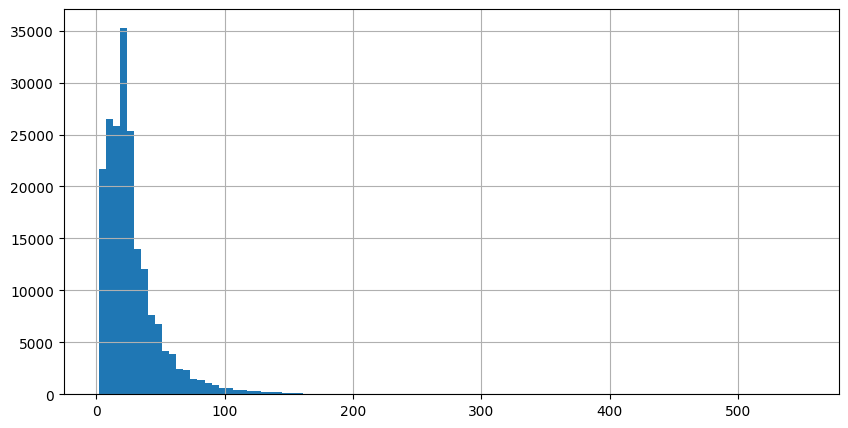

,id,review_body,stars,language,lenght_review_body,review_body_clean,review_length_words
87137,106299,"Hago estos cambios en mi opinión, no por el pr...",5,es,3086,hago estos cambios en mi opinión no por el pro...,551
2949,69222,Compré esta depiladora recomendada por una ami...,2,es,2898,compré esta depiladora recomendada por una ami...,495
104323,128410,La idea de este producto está bastante bien: m...,2,es,2727,la idea de este producto está bastante bien ma...,470


In [12]:
# ============================================================
# A.4.6) Analisis de longitud de comenatios
# ============================================================
df["review_length_words"] = (
    df["review_body_clean"]
    .astype(str)
    .str.split()
    .str.len()
)

df.head(3)
df["review_length_words"].max()
df["review_length_words"].hist(bins=100, figsize=(10, 5))
plt.show()

df[df["review_length_words"] == 0].head(20)
df.sort_values("review_length_words", ascending=False).head(3)

In [13]:
# ============================================================
# A.4.6.a) Creación de la etiqueta de sentimiento (Labeling)
# ============================================================
def sentimiento(stars):
    if stars <= 2:
        return "negativo"
    elif stars == 3:
        return "neutro"
    else:
        return "positivo"

df["sentiment"] = df["stars"].apply(sentimiento)

In [14]:
# ============================================================
# A.4.7.a) Balanceo y validación de clases
# ============================================================
df["sentiment"].value_counts(normalize=True)

,proportion
sentiment,
negativo,0.401935
positivo,0.397514
neutro,0.200551


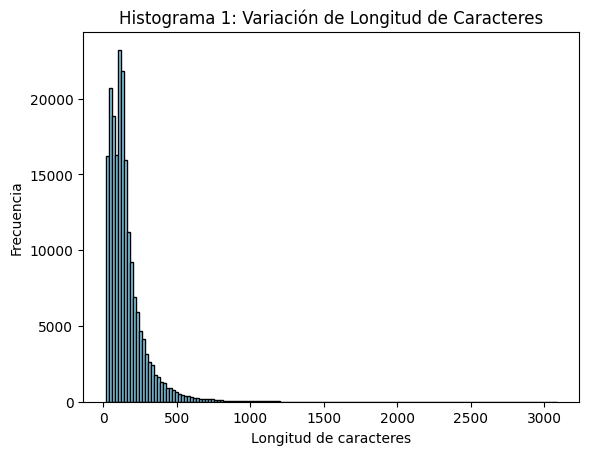

In [15]:
# ============================================================
# A.4.8) Análisis estadístico para tomar subconjuntos del DataSet
#      (500, 1000, 5000 y 40000) para el entrenamiento del modelo
# Esti se hizo con el fin de compaarar inicialemte como era el comportamiento
# de los modelos clásicos al entrenarlos con diferentes tamaños de datasets.
# ============================================================
def Histograma(dataframe, xlabel, ylabel, title, bin=150):
    plt.hist(dataframe, bins=bin, color="skyblue", edgecolor="black")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return plt.show()

Histograma(
    df["lenght_review_body"],
    "Longitud de caracteres",
    "Frecuencia",
    "Histograma 1: Variación de Longitud de Caracteres"
)


In [16]:
# ============================================================
# Muestreo estratificado
# ============================================================
def DataSets(df, n):
    return (
        df.groupby("sentiment", group_keys=False)
        .apply(
            lambda x: x.sample(
                n=int(len(x) / len(df) * n),
                random_state=42
            )
        )
    )


# ============================================================
# Asegurar tamaño EXACTO n (corrige redondeo)
# Mantiene la estructura original, pero ajusta el muestreo para
# que el total sea exactamente n.
# ============================================================
def DataSets_exact(df, n):
    # 1) Muestra estratificada aproximada (misma lógica original)
    df_sample = DataSets(df, n)

    # 2) Ajuste para que quede EXACTAMENTE n
    if len(df_sample) > n:
        df_sample = df_sample.sample(n=n, random_state=42)
    elif len(df_sample) < n:
        faltan = n - len(df_sample)

        # candidatos: filas que no están en el sample
        restantes = df.drop(df_sample.index, errors="ignore")

        # completar con filas extra (si hay suficientes)
        if len(restantes) >= faltan:
            extra = restantes.sample(n=faltan, random_state=42)
            df_sample = pd.concat([df_sample, extra], axis=0)
        else:
            # si no hay suficientes, se deja lo máximo posible
            df_sample = pd.concat([df_sample, restantes], axis=0)

    # mezclar para evitar bloques por clase
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_sample


In [18]:
# Subconjuntos
df_500 = DataSets_exact(df, 500)
df_1000 = DataSets_exact(df, 1000)
df_5000 = DataSets_exact(df, 5000)
df_40000 = DataSets_exact(df, 40000)

df_completo = df.copy()

df_40000.info()

/tmp/ipython-input-167989245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-167989245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-167989245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   40000 non-null  uint32
 1   review_body          40000 non-null  object
 2   stars                40000 non-null  int64 
 3   language             40000 non-null  object
 4   lenght_review_body   40000 non-null  uint32
 5   review_body_clean    40000 non-null  object
 6   review_length_words  40000 non-null  int64 
 7   sentiment            40000 non-null  object
dtypes: int64(2), object(4), uint32(2)
memory usage: 2.1+ MB


/tmp/ipython-input-167989245.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [19]:
# ============================================================
# Guardando los DataSets (columnas finales)
# ============================================================
df_500_fx = df_500[["id", "review_body", "stars", "language", "lenght_review_body", "review_body_clean", "sentiment"]]
df_1000_fx = df_1000[["id", "review_body", "stars", "language", "lenght_review_body", "review_body_clean", "sentiment"]]
df_5000_fx = df_5000[["id", "review_body", "stars", "language", "lenght_review_body", "review_body_clean", "sentiment"]]
df_40000_fx = df_40000[["id", "review_body", "stars", "language", "lenght_review_body", "review_body_clean", "sentiment"]]
df_completo_fx = df_completo[["id", "review_body", "stars", "language", "lenght_review_body", "review_body_clean", "sentiment"]]


df_500_fx = df_500_fx.sort_values(by="id", ignore_index=True)
df_1000_fx = df_1000_fx.sort_values(by="id", ignore_index=True)
df_5000_fx = df_5000_fx.sort_values(by="id", ignore_index=True)
df_40000_fx = df_40000_fx.sort_values(by="id", ignore_index=True)
df_completo_fx = df_completo_fx.sort_values(by="id", ignore_index=True)

In [ ]:
# ============================================================
# Exportando los DataSets a .csv para su uso en el entrenamiento
# ============================================================
df_500_fx.to_csv("df_500_fx.csv", index=False)
df_1000_fx.to_csv("df_1000_fx.csv", index=False)
df_5000_fx.to_csv("df_5000_fx.csv", index=False)
df_40000_fx.to_csv("df_40000_fx.csv", index=False)
df_completo_fx.to_csv("df_completo_fx.csv", index=False)

## B) Proceso ETL para DataSet en Portugués

### B.1) El Dataset
El DataSet utilizado para el proceso es un conjunto de datos (sentiment_reviews_olist_pt.csv) de reseñas en portugués, orientado a tareas de procesamiento de lenguaje natural como clasificación y análisis de sentimiento.

Para nuestro caso, nos enfocaremos en la columna `"review_body"`.

#### Aclaración técnica: ¿Por qué el ETL en Portugués no es idéntico al de Español?

Aunque el objetivo del proyecto es el mismo (Análisis de Sentimiento), el pipeline de Transformación se ajusta ligeramente entre Español (ES) y Portugués (PT) por razones de calidad lingüística, estructura del dataset y consistencia del etiquetado.

1) Diferencias en caracteres válidos del idioma (limpieza de texto)
    - Español: á, é, í, ó, ú, ñ, ü
    - Portugués: á, é, í, ó, ú, â, ê, î, ô, û, ã, õ, ç, à

    Decisión:
    La regex de limpieza debe ser distinta, porque si se usa la de español en portugués, se eliminan letras válidas y se altera el texto real.

2) Estructura y “contrato” del dataset de entrada
    - En ES (Hugging Face) suele existir stars, language, review_body, lenght_review_body.
    - En PT (CSV) es común que:
         * ya exista la etiqueta sentiment
         * no exista language o venga inconsistente
         * cambien nombres de columnas según el origen del dataset

    Decisión:
    En PT se incluye lógica adicional para:
    - crear id si no existe
    - forzar language="pt" si no está presente
    - usar sentiment si ya viene definida

3) Etiquetado: derivar desde estrellas vs usar etiqueta original
    - En ES: se crea sentiment desde stars (1-2 neg, 3 neu, 4-5 pos).
    - En PT: si ya existe sentiment, se respeta y se normaliza.

 4) Objetivo común: reproducibilidad y comparabilidad
    Ambos ETL entregan:
    - review_body_clean
    - sentiment
    - deduplicación
    - control de nulos/vacíos
    - muestreo estratificado para entrenamiento

### B.2) Extracción de archivos (Extract)

In [36]:
df = pd.read_csv("sentiment_reviews_olist_pt.csv")
df.head(3)

# ============================================================
# 4.1-. Validaciones iniciales
# ============================================================
df.info()
df.shape

# Si existe una columna de longitud, se puede revisar (opcional)
if "lenght_review_body" in df.columns:
    df["lenght_review_body"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40950 entries, 0 to 40949
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review_id               40950 non-null  object 
 1   order_id                40950 non-null  object 
 2   review_score            40950 non-null  int64  
 3   review_comment_message  40950 non-null  object 
 4   sentiment_label_raw     40950 non-null  object 
 5   sentiment_score_raw     40950 non-null  float64
 6   sentiment_stars         40950 non-null  int64  
 7   sentiment_polarity      40950 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ MB


### B.3) Trasformación

Aquí se limpia, normaliza y estructura el texto para que el modelo pueda aprender patrones reales.

La transformación se divide en sub-etapas lógicas:
1) Selección de columnas relevantes
2) Eliminación de nulos
3) Normalización de idioma
4) Eliminación de comentarios duplicados
5) Limpieza de texto (Text Cleaning)
6) Creación de la etiqueta de sentimiento (Labeling)
7) Balanceo y validación de clases
8) Análisis estadístico para tomar un subconjunto de datos del DataSet (5000), para el entrenamiento del modelo.

#### B.3.1) Selección de columnas relevantes

Contrato real del dataset (según df.info()):
- review_id               -> ID principal
- order_id                -> ID de orden
- review_score            -> estrellas reales del usuario (1 a 5)
- review_comment_message  -> texto (columna principal)
- sentiment_label_raw     -> etiqueta ya generada  (principal)
- sentiment_score_raw     -> score continuo
- sentiment_stars         -> estrellas derivadas por el sistema (si aplica)
- sentiment_polarity      -> polaridad numérica (si aplica)

Se mantiene trazabilidad exportando tanto label como score.

In [37]:
df = df[
    [
        "review_id",
        "order_id",
        "review_score",
        "review_comment_message",
        "sentiment_label_raw",
        "sentiment_score_raw",
        "sentiment_stars",
        "sentiment_polarity",
    ]
].copy()

In [38]:
# ============================================================
# B.3.2) Eliminación de elementos nulos
# ============================================================
# Un comentario vacío no aporta información semántica.
df = df.dropna(subset=["review_comment_message"])

In [39]:
# ============================================================
# B.3.3) Normalización de idioma
# ============================================================
# Este dataset es portugués. Si no existe columna language, la creamos.
df["language"] = "pt"

In [40]:
# ============================================================
# B.3.4) Eliminación de comentarios duplicados
# ============================================================
# Normalización mínima para detectar duplicados sin perder trazabilidad.
df["review_body_clean"] = (
    df["review_comment_message"]
    .astype(str)
    .str.lower()
    .str.strip()
)

df = df.drop_duplicates(subset=["review_body_clean"])
df.head(3)

,review_id,order_id,review_score,review_comment_message,sentiment_label_raw,sentiment_score_raw,sentiment_stars,sentiment_polarity,language,review_body_clean
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,3 stars,0.399876,3,0,pt,recebi bem antes do prazo estipulado.
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5 stars,0.538074,5,1,pt,parabéns lojas lannister adorei comprar pela i...
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,3 stars,0.361089,3,0,pt,aparelho eficiente. no site a marca do aparelh...


In [41]:
# ============================================================
# B.3.5) Limpieza de texto (Text Cleaning)
# ============================================================
# Para portugués se conservan letras con acentos comunes:
# áéíóúâêîôûãõçà + espacios
#
# NOTA:
# Esta limpieza elimina números y puntuación.
# Es una decisión controlada para homogeneidad del dataset.
df["review_body_clean"] = (
    df["review_comment_message"]
    .astype(str)
    .str.lower()
    .str.replace(r"http\S+", "", regex=True)
    .str.replace(r"[^a-záéíóúâêîôûãõçà\s]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df = df.drop_duplicates(subset=["review_body_clean"])

In [42]:
# ============================================================
# Control de vacíos tras limpieza
# ============================================================
df = df[df["review_body_clean"].str.len() > 0].copy()

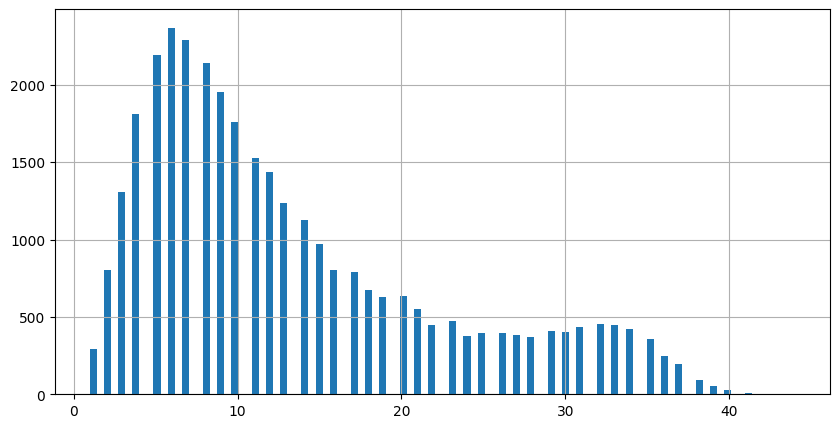

,review_id,order_id,review_score,review_comment_message,sentiment_label_raw,sentiment_score_raw,sentiment_stars,sentiment_polarity,language,review_body_clean,review_length_words
10638,d71da8fd8c6e3adef26be965f065b8a1,e17e4f88e31525f7deef66779844ddce,5,Super adooorei o delineador ele é bem preto e ...,4 stars,0.622217,4,1,pt,super adooorei o delineador ele é bem preto e ...,44
27740,9aa0f0428e7491e8bcf0f21626119b88,665529c259350d60618eca48496ea75d,1,Eu pedi 110 e veio 220 e não consigo fazer a t...,1 star,0.875615,1,-1,pt,eu pedi e veio e não consigo fazer a troca ja ...,43
16934,ea98b47899516adbcf3bfe4f7e491587,cf650037c918409bca8e5e67ee7dcfbe,1,Propaganda enganosa lá na descrição diz que o ...,1 star,0.678710,1,-1,pt,propaganda enganosa lá na descrição diz que o ...,43
32687,f3385706bfd641f3c8b82fe18edf12dd,d5ea2169e37b50c52923ed4e62482bda,2,"A entrega veio incompleta, só veio a película ...",1 star,0.600945,1,-1,pt,a entrega veio incompleta só veio a película s...,43
31314,b705e9809054fd5c6dc07e09d2a17043,b2f39212b22fb44dc0d57cdd6d1790dc,1,A loja mantém a venda de produtor que ela n te...,1 star,0.588582,1,-1,pt,a loja mantém a venda de produtor que ela n te...,42
25912,b123c87a07ac962184a21b6cbf967f8f,0c1457493ca1492c4a4417fc278605b0,1,"Recebi no prazo certo, mas não foi o produto q...",1 star,0.400311,1,-1,pt,recebi no prazo certo mas não foi o produto qu...,41
2301,2a36c88b839e9be4c119d26cbe5f0e80,228b82b829438b71d9b164c1a8cea481,1,Realizei a compra e o pgto no msm dia e ele fo...,1 star,0.697064,1,-1,pt,realizei a compra e o pgto no msm dia e ele fo...,41
5630,7dc116ac2efa5620c4b8cca7093b3e11,2ca9036cf880a76f0a41894ede902e55,4,"Mas chegou dentro do prazo que foi dado, foi e...",2 stars,0.363313,2,-1,pt,mas chegou dentro do prazo que foi dado foi en...,41
32336,1540a1a2cf3051a12025106af974e104,a2b01f72ab3f4fc8831837432d5a0117,3,não sei se eu não prestei a atenção devida qua...,4 stars,0.443708,4,1,pt,não sei se eu não prestei a atenção devida qua...,41
3304,2ca08c633d4c824cf268e25c3ed435bc,5ba8503668408d9c4b89795726cb7f4e,1,O cartão que recebi é falso.\r\nComeçou com a ...,1 star,0.574929,1,-1,pt,o cartão que recebi é falso começou com a cor ...,41


In [43]:
# ============================================================
# B.3.6) Analisis de longitud de comenatios
# ============================================================
df["review_length_words"] = (
    df["review_body_clean"]
    .astype(str)
    .str.split()
    .str.len()
)

df.head(3)
df["review_length_words"].max()
df["review_length_words"].hist(bins=100, figsize=(10, 5))
plt.show()

df[df["review_length_words"] == 0].head(20)
df.sort_values("review_length_words", ascending=False).head(20)

In [44]:
# ============================================================
# B.3.6.a) Creación / normalización de la etiqueta de sentimiento (Labeling)
# ============================================================
# En PT ya existe "sentiment_label_raw", por lo cual:
# - se respeta como etiqueta principal
# - se normaliza a minúsculas
df["sentiment"] = df["sentiment_label_raw"].astype(str).str.upper().str.strip()

# Opcional: mapear a las mismas clases del proyecto (negativo/neutro/positivo)
# Si tu dataset ya usa estas 3 clases, no cambia nada.
# Si usa otras (ej: "positive", "neutral", "negative"), lo normaliza.
mapping_sentiment = {
    "positive": "POSITIVO",
    "neutral": "NEUTRO",
    "negative": "NEGATIVO",
    "positivo": "POSITIVO",
    "neutro": "NEUTRO",
    "negativo": "NEGATIVO",
}

df["sentiment"] = df["sentiment"].map(mapping_sentiment).fillna(df["sentiment"])

En el dataset PT la etiqueta viene como texto X stars, por lo cual se normaliza extrayendo el número y mapeándolo a 3 clases finales (NEGATIVO/NEUTRO/POSITIVO) para mantener consistencia con el pipeline en español

In [48]:
# ============================================================
# Labeling (PT): Convertir "X stars" -> NEGATIVO / NEUTRO / POSITIVO (MAYÚSCULAS)
# ============================================================

# 1) Extraer el número de estrellas desde "sentiment_label_raw" (ej: "3 stars" -> 3)
df["sentiment_stars_from_label"] = (
    df["sentiment_label_raw"]
    .astype(str)
    .str.lower()
    .str.extract(r"(\d+)")   # captura el número
    .astype(float)
    .astype("Int64")         # permite nulos si algo viene raro
)

# 2) Crear sentimiento en MAYÚSCULAS con regla estándar
def stars_to_sentiment(stars):
    if pd.isna(stars):
        return np.nan
    if stars <= 2:
        return "NEGATIVO"
    elif stars == 3:
        return "NEUTRO"
    else:
        return "POSITIVO"

df["sentiment"] = df["sentiment_stars_from_label"].apply(stars_to_sentiment)

# 3) Validación rápida
df["sentiment"].value_counts(dropna=False)

,count
sentiment,
POSITIVO,16707
NEGATIVO,13942
NEUTRO,3036


In [49]:
df.head(3)

,review_id,order_id,review_score,review_comment_message,sentiment_label_raw,sentiment_score_raw,sentiment_stars,sentiment_polarity,language,review_body_clean,review_length_words,sentiment,sentiment_stars_from_label
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,3 stars,0.399876,3,0,pt,recebi bem antes do prazo estipulado,6,NEUTRO,3
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5 stars,0.538074,5,1,pt,parabéns lojas lannister adorei comprar pela i...,15,POSITIVO,5
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,3 stars,0.361089,3,0,pt,aparelho eficiente no site a marca do aparelho...,30,NEUTRO,3


In [50]:
# ============================================================
# B.3.7) Balanceo y validación de clases
# ============================================================
df["sentiment"].value_counts(normalize=True)

,proportion
sentiment,
POSITIVO,0.495977
NEGATIVO,0.413893
NEUTRO,0.090129


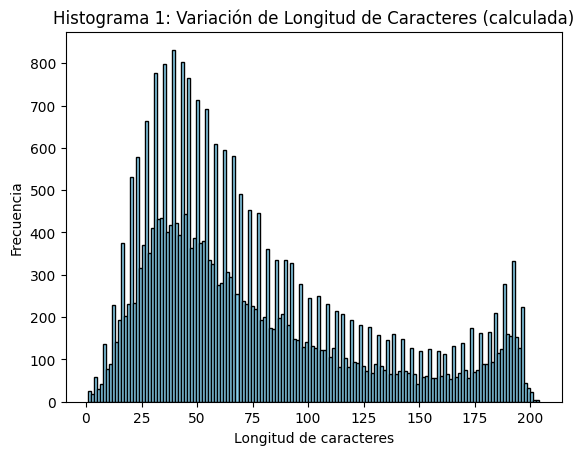

In [51]:
# ============================================================
# 5.8-. Análisis estadístico para tomar subconjuntos del DataSet
#      (500, 1000, 5000 y 40000) para el entrenamiento del modelo
# ============================================================
def Histograma(dataframe, xlabel, ylabel, title, bin=150):
    plt.hist(dataframe, bins=bin, color="skyblue", edgecolor="black")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return plt.show()

# Longitud en caracteres (calculada) ya que el dataset no trae "lenght_review_body"
df["length_review_body_calc"] = df["review_body_clean"].str.len()

Histograma(
    df["length_review_body_calc"],
    "Longitud de caracteres",
    "Frecuencia",
    "Histograma 1: Variación de Longitud de Caracteres (calculada)"
)

In [52]:
# ============================================================
# Muestreo estratificado
# ============================================================
def DataSets(df, n):
    return (
        df.groupby("sentiment", group_keys=False)
        .apply(
            lambda x: x.sample(
                n=int(len(x) / len(df) * n),
                random_state=42
            )
        )
    )

In [53]:
# ============================================================
# Asegurar tamaño EXACTO n (corrige redondeo)
# Mantiene tu estructura original, pero ajusta el muestreo para
# que el total sea exactamente n.
# ============================================================
def DataSets_exact(df, n):
    df_sample = DataSets(df, n)

    if len(df_sample) > n:
        df_sample = df_sample.sample(n=n, random_state=42)
    elif len(df_sample) < n:
        faltan = n - len(df_sample)
        restantes = df.drop(df_sample.index, errors="ignore")

        if len(restantes) >= faltan:
            extra = restantes.sample(n=faltan, random_state=42)
            df_sample = pd.concat([df_sample, extra], axis=0)
        else:
            df_sample = pd.concat([df_sample, restantes], axis=0)

    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_sample


In [55]:
# Subconjuntos
df_500 = DataSets_exact(df, 500)
df_1000 = DataSets_exact(df, 1000)
df_5000 = DataSets_exact(df, 5000)

df_completo = df.copy()

/tmp/ipython-input-2442383117.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-2442383117.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipython-input-2442383117.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

In [57]:
# ============================================================
# Guardando los DataSets (columnas finales)
# ============================================================
# Se exporta un set estándar para entrenamiento:
# - IDs (trazabilidad)
# - texto original
# - texto limpio
# - etiqueta final
# - métricas adicionales (score/polarity) si se desean auditar
# ============================================================
cols_finales = [
    "review_id",
    "order_id",
    "review_comment_message",
    "review_score",
    "sentiment_label_raw",
    "sentiment_score_raw",
    "sentiment_stars",
    "sentiment_polarity",
    "language",
    "length_review_body_calc",
    "review_body_clean",
    "sentiment",
]

df_500_pt = df_500[cols_finales].copy()
df_1000_pt = df_1000[cols_finales].copy()
df_5000_pt = df_5000[cols_finales].copy()
df_completo_pt = df_completo[cols_finales].copy()

In [58]:
# ============================================================
# Evitar SettingWithCopyWarning
# No usar inplace=True; reasignar el DataFrame ordenado.
# ============================================================
df_500_pt = df_500_pt.sort_values(by="review_id", ignore_index=True)
df_1000_pt = df_1000_pt.sort_values(by="review_id", ignore_index=True)
df_5000_pt = df_5000_pt.sort_values(by="review_id", ignore_index=True)
df_completo_pt = df_completo_pt.sort_values(by="review_id", ignore_index=True)

In [ ]:
# ============================================================
# Exportando los DataSets a .csv para su uso en el entrenamiento
# ============================================================
df_500_fx.to_csv("df_500_fx_pt.csv", index=False)
df_1000_fx.to_csv("df_1000_fx_pt.csv", index=False)
df_5000_fx.to_csv("df_5000_fx_pt.csv", index=False)
df_completo_fx.to_csv("df_completo_fx_pt.csv", index=False)

# Modelos Implementados

## 1) Árbol de Decisión (Decision Tree)

**Autor: Faxin Andres Pabuena Yepes - DS**

- Tipo: Machine Learning tradicional (modelo basado en reglas).
- Fortalezas:
  - Alta interpretabilidad (se entiende qué reglas usa para decidir).
  - Rápido de entrenar en datasets pequeños/medianos.

- Limitaciones:
  - Tiende a sobreajustar (overfitting) si no se controla profundidad y poda.
  - No captura bien relaciones complejas del lenguaje sin buena representación previa.
- Uso recomendado: Baseline explicable y validación rápida.


### 1.1) Pipeline

In [11]:
# ============================================================
# 1. Construcción de la variable objetivo (Sentiment)
# ============================================================
# A partir de la calificación en estrellas (stars), se genera una etiqueta
# de sentimiento con una regla de negocio simple:
#   - 1 y 2 estrellas  -> Negativo
#   - 3 estrellas      -> Neutro
#   - 4 y 5 estrellas  -> Positivo
# Esto permite transformar un valor numérico en una clase categórica
# para entrenamiento de modelos de clasificación.

def sentimiento(stars):
    if stars <= 2:
        return 'Negativo'
    elif stars == 3:
        return 'Neutro'
    else:
        return 'Positivo'

df['sentiment'] = df['stars'].apply(sentimiento)

df.head(3)

,id,review_body,stars,language,lenght_review_body,review_body_clean,sentiment
0,0,"sí es totalmente impermeable, pero no se adapt...",3,es,144,sí es totalmente impermeable pero no se adapta...,Neutro
1,1,el precio esta bien del producto pero el embal...,3,es,174,el precio esta bien del producto pero el embal...,Neutro
2,2,De momento va muy bien y tiene un diseño muy e...,5,es,54,de momento va muy bien y tiene un diseño muy e...,Positivo


In [12]:
# ============================================================
# 2. Segmentación del dataset por calificación (stars)
# ============================================================
# Se crean subconjuntos independientes para analizar el comportamiento
# del texto y la distribución de datos por cada nivel de estrellas (1 a 5).
# Esto facilita validaciones, exploración y análisis de sesgos.

df_1 = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2]
df_3 = df[df['stars'] == 3]
df_4 = df[df['stars'] == 4]
df_5 = df[df['stars'] == 5]

In [13]:
# ============================================================
# 3. Definición de variables de entrada (X) y objetivo (y)
# ============================================================
# X_texto: contenido textual del comentario (feature principal).
# X_longitud: variable numérica adicional (longitud del comentario),
#             útil como señal complementaria para el modelo.
# y: etiqueta final de sentimiento (target) generada previamente.

X_texto = df['review_body']                 # Texto del comentario
X_longitud = df[['lenght_review_body']]     # Longitud del comentario (feature numérica)
y = df['sentiment']                         # Variable objetivo (clase)

In [14]:
# ============================================================
# 4. Vectorización del texto (TF-IDF)
# ============================================================
# Se transforma el texto en una representación numérica usando TF-IDF,
# permitiendo que modelos tradicionales trabajen con lenguaje natural.
# Configuración clave:
# - max_features: controla el tamaño del vocabulario (eficiencia / velocidad).
# - ngram_range: (1,1) usa únicamente unigramas (palabras individuales).
# - min_df: elimina términos muy raros para reducir ruido y mejorar generalización.

vectorizer_tree = TfidfVectorizer(
    max_features=300,
    ngram_range=(1, 1),
    min_df=2
)

# Matriz dispersa (sparse matrix) con las features TF-IDF del texto
X_texto_vec = vectorizer_tree.fit_transform(X_texto)

In [15]:
# ============================================================
# 5. Construcción del feature set final y partición Train/Test
# ============================================================
# Se combinan:
# - Features textuales (TF-IDF) -> X_texto_vec
# - Feature numérica adicional (longitud del comentario) -> X_longitud
# Esto permite que el modelo aproveche señales semánticas + estructurales.

X_final = hstack([X_texto_vec, X_longitud.values])

# División del dataset en entrenamiento y prueba
# - test_size=0.2: 80% train / 20% test
# - stratify=y: mantiene la proporción de clases (Negativo/Neutro/Positivo)
# - random_state: asegura reproducibilidad del experimento
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [18]:
# ============================================================
# 6. Modelo: Árbol de Decisión (Decision Tree)
# ============================================================
# Se define un Árbol de Decisión como modelo base interpretable.
# Parámetros principales:
# - max_depth: controla la complejidad del árbol y reduce overfitting.
# - min_samples_leaf: evita hojas con muy pocas muestras (mejor generalización).
# - class_weight='balanced': compensa desbalance entre clases automáticamente.
# - random_state: asegura resultados reproducibles.

tree_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)


In [19]:
# Entrenamiento del modelo con el conjunto de entrenamiento
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=42)

In [20]:
# ============================================================
# 7. Evaluación del modelo (Árbol de Decisión)
# ============================================================
# Se generan predicciones sobre el conjunto de prueba y se calculan
# métricas estándar de clasificación:
# - Accuracy: desempeño global
# - Classification Report: precision, recall y f1-score por clase

y_pred_tree = tree_model.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)

print("Accuracy Árbol de Decisión:", round(accuracy_tree, 2))
print(classification_report(y_test, y_pred_tree))


Accuracy Árbol de Decisión: 0.54
              precision    recall  f1-score   support

    Negativo       0.66      0.46      0.54     15840
      Neutro       0.32      0.45      0.37      7903
    Positivo       0.61      0.67      0.64     15665

    accuracy                           0.54     39408
   macro avg       0.53      0.53      0.52     39408
weighted avg       0.57      0.54      0.55     39408



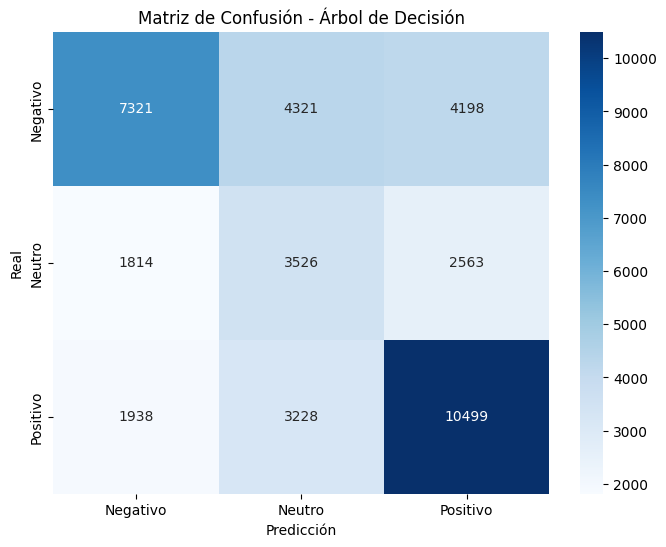

In [23]:
# Calcular la matriz de confusión
cmDecisionTree = confusion_matrix(y_test, y_pred_tree, labels=['Negativo', 'Neutro', 'Positivo'])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cmDecisionTree, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Neutro', 'Positivo'],
            yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

In [24]:
cmDecisionTree

array([[ 7321,  4321,  4198],
       [ 1814,  3526,  2563],
       [ 1938,  3228, 10499]])

In [25]:
# ============================================================
# Exportación de métricas y matriz de confusión (Árbol de Decisión)
# ============================================================

labels = ['Negativo', 'Neutro', 'Positivo']

# 1) Reporte de clasificación (como tabla)
reporte_dict = classification_report(y_test, y_pred_tree, output_dict=True)
df_metricas = pd.DataFrame(reporte_dict).transpose()

# Guardar métricas
df_metricas.to_csv("metricas_decision_tree.csv", index=True)

# 2) Matriz de confusión (como tabla)
cm = confusion_matrix(y_test, y_pred_tree, labels=labels)
df_cm = pd.DataFrame(cm, index=[f"Real_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])

# Guardar matriz de confusión
df_cm.to_csv("matriz_confusion_decision_tree.csv", index=True)

print("Exportación completada:")
print("- metricas_decision_tree.csv")
print("- matriz_confusion_decision_tree.csv")


Exportación completada:
- metricas_decision_tree.csv
- matriz_confusion_decision_tree.csv


In [26]:
# ============================================================
# 8. Función de limpieza y normalización de texto
# ============================================================
# Se estandariza el texto antes de vectorizarlo, con el fin de:
# - Reducir ruido (símbolos, puntuación innecesaria)
# - Unificar formato (minúsculas)
# - Mejorar consistencia entre entrenamiento e inferencia

def limpiar_texto(texto: str) -> str:
    """
    Limpieza básica del texto para procesamiento NLP.

    Pasos:
    1) Convierte a minúsculas.
    2) Elimina caracteres especiales (conserva letras y espacios).
    3) - Elimina espacios extras
    """
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto


In [27]:
# ============================================================
# 9. Función de inferencia: Predicción con Árbol de Decisión
# ============================================================
# Esta función permite usar el modelo entrenado para predecir el sentimiento
# de un nuevo comentario en texto libre.
# Flujo:
# 1) Limpieza y normalización del texto
# 2) Vectorización TF-IDF (mismas features del entrenamiento)
# 3) Cálculo de feature numérica adicional (longitud del texto)
# 4) Concatenación de features (texto + longitud)
# 5) Predicción final con el modelo

def predecir_sentimiento_arbol(texto):
    # 1) Limpieza del texto para asegurar consistencia con el entrenamiento
    texto_limpio = limpiar_texto(texto)

    # 2) Vectorización del texto usando el TF-IDF ya entrenado
    texto_vec = vectorizer_tree.transform([texto_limpio])

    # 3) Feature numérica adicional: longitud del comentario (en caracteres)
    longitud = np.array([[len(texto_limpio)]])

    # 4) Construcción del vector final de entrada (texto + longitud)
    X_nuevo = hstack([texto_vec, longitud])

    # 5) Predicción del sentimiento
    sentimiento = tree_model.predict(X_nuevo)[0]

    return (
        f"Sentimiento (Árbol de Decisión): {sentimiento} | "
        f"Precisión del modelo: {round(accuracy_tree, 2)}"
    )


In [28]:
# Ejemplo de inferencia con un texto corto
predecir_sentimiento_arbol("Lamentable")

'Sentimiento (Árbol de Decisión): Positivo | Precisión del modelo: 0.54'

In [30]:
# ============================================================
# 10. Persistencia del modelo y componentes del pipeline
# ============================================================
# Se guarda:
# - tree_model: modelo entrenado (DecisionTreeClassifier)
# - vectorizer_tree: TF-IDF entrenado con el vocabulario final
# Esto permite desplegar el modelo y ejecutar inferencia en nuevos textos.

joblib.dump(tree_model, "modelo_arbol_decision.pkl")
joblib.dump(vectorizer_tree, "modelo_arbol_decision_vectorizador_.pkl")

print("Modelo Árbol de Decisión y vectorizador TF-IDF guardados correctamente.")


Modelo Árbol de Decisión y vectorizador TF-IDF guardados correctamente.


### 1.2) Análisis y Conclusiones - Árbol de Decisión

#### 1) Resultado general
- **Accuracy = 0.54**  
  El modelo acierta **54%** de los casos. Para un problema de **3 clases (Negativo/Neutro/Positivo)**, es un desempeño **moderado**, pero aún insuficiente para un entregable productivo sin mejoras.

- **Weighted F1 = 0.55**  
  Confirma que el rendimiento global es aceptable, pero **irregular por clase**, especialmente en *Neutro*.

---

#### 2) Lectura por clase (Precision / Recall / F1)

##### Negativo
- **Precision = 0.66** → Cuando predice *Negativo*, suele acertar.
- **Recall = 0.46** → Solo detecta **46%** de los negativos reales.
- **Conclusión:** El modelo **pierde muchos negativos** (los confunde con Neutro o Positivo).

##### Neutro
- **Precision = 0.32** → Cuando predice *Neutro*, se equivoca mucho.
- **Recall = 0.45** → Recupera ~45% de los neutros reales.
- **Conclusión:** *Neutro* es la clase **más débil**: el modelo la predice con baja confiabilidad y además se mezcla con las otras dos.

##### Positivo
- **Precision = 0.61** → Predicciones positivas relativamente confiables.
- **Recall = 0.67** → Detecta **67%** de los positivos reales.
- **Conclusión:** Es la clase **mejor aprendida** por el modelo.

---

#### 3) Interpretación de la Matriz de Confusión

Matriz:

| Real \ Pred | Negativo | Neutro | Positivo |
|---|---:|---:|---:|
| **Negativo** | 7321 | 4321 | 4198 |
| **Neutro**   | 1814 | 3526 | 2563 |
| **Positivo** | 1938 | 3228 | 10499 |

##### Hallazgos clave

**A) Negativos confundidos como Neutros o Positivos**
- Negativos bien clasificados: **7321**
- Negativos mal clasificados:
  - como Neutro: **4321**
  - como Positivo: **4198**
- **Lectura:** el modelo **no logra separar bien el lenguaje negativo**, especialmente cuando el texto es corto, ambiguo o contiene ironía.

**B) La clase Neutro es la más “inestable”**
- Neutros correctos: **3526**
- Neutros mal clasificados:
  - como Negativo: **1814**
  - como Positivo: **2563**
- **Lectura:** “Neutro” se está comportando como una clase **intermedia** que el modelo no entiende bien, y termina empujando ejemplos hacia extremos.

**C) Positivo se detecta mejor, pero aún se confunde con Neutro**
- Positivos correctos: **10499**
- Positivos mal clasificados:
  - como Negativo: **1938**
  - como Neutro: **3228**
- **Lectura:** aunque es la mejor clase, todavía hay una fuga importante hacia *Neutro*.

---

Este Árbol de Decisión funciona como un **baseline interpretable**, pero su desempeño está limitado por:

1. **Capacidad baja para capturar semántica** (reglas simples frente a lenguaje natural).
2. **Alta confusión con la clase Neutro**, que actúa como “zona gris”.
3. **Recall bajo en Negativo**, lo cual es crítico si el objetivo es detectar quejas o riesgo de churn.

---

## 2) Naive Bayes

**Autora: Adelina Escobar Acevedo - DS**

- Tipo: Clasificador probabilístico (asume independencia entre palabras).
- Fortalezas:
  - Muy eficiente en texto, especialmente con representaciones tipo bag-of-words / TF-IDF.
  - Entrenamiento y predicción muy rápidos.
  - Suele funcionar bien como modelo base en NLP.
- Limitaciones:
  - La suposición de independencia es irreal para lenguaje natural.
  - Puede perder precisión en textos ambiguos o con contexto complejo.
- Uso recomendado: Baseline rápido y sólido para texto.

### 2.1) Pipeline

In [3]:
# ============================================================
# 1. Carga del dataset consolidado
# ============================================================
# Se utiliza el dataset final ya preprocesado, incluyendo:
# - review_body_clean: texto limpio
# - sentiment: etiqueta objetivo (Negativo / Neutro / Positivo)
# ============================================================

df = pd.read_csv("df_completo_fx.csv")
print("Dataset cargado:", df.shape)

Dataset cargado: (197037, 7)


In [4]:
# ============================================================
# 2. Definición de variables (X, y)
# ============================================================
X_texto = df["review_body_clean"].fillna("")  # evita errores por NaN
y = df["sentiment"]

In [5]:
# ============================================================
# 3. Vectorización del texto (TF-IDF)
# ============================================================
# Convierte el texto en una matriz numérica dispersa.
# - ngram_range=(1,1): unigramas
# - min_df=2: elimina términos extremadamente raros
# ============================================================

vectorizer_nb = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=2
)

X_texto_vec = vectorizer_nb.fit_transform(X_texto)

In [6]:
# ============================================================
# 4. División Train/Test
# ============================================================
# stratify=y mantiene la proporción de clases.
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_texto_vec,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [7]:
# ============================================================
# 5. Entrenamiento: Multinomial Naive Bayes
# ============================================================
# alpha: suavizado de Laplace
# fit_prior: aprende probabilidades previas de clases
# ============================================================

nb_model = MultinomialNB(
    alpha=1.0,
    fit_prior=True
)

nb_model.fit(X_train, y_train)


MultinomialNB()

In [8]:
# ============================================================
# 6. Evaluación del modelo (MultinomialNB)
# ============================================================

y_pred_nb = nb_model.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("\nAccuracy Naive Bayes:", round(accuracy_nb, 2))
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


Accuracy Naive Bayes: 0.69

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    negativo       0.69      0.85      0.76     15840
      neutro       0.47      0.04      0.07      7903
    positivo       0.69      0.85      0.76     15665

    accuracy                           0.69     39408
   macro avg       0.62      0.58      0.53     39408
weighted avg       0.65      0.69      0.62     39408



In [9]:
# ============================================================
# 7. Exportación de métricas a CSV
# ============================================================

report_dict = classification_report(y_test, y_pred_nb, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("metricas_naive_bayes.csv", index=True)

print("\nMétricas exportadas: metricas_naive_bayes.csv")


Métricas exportadas: metricas_naive_bayes.csv


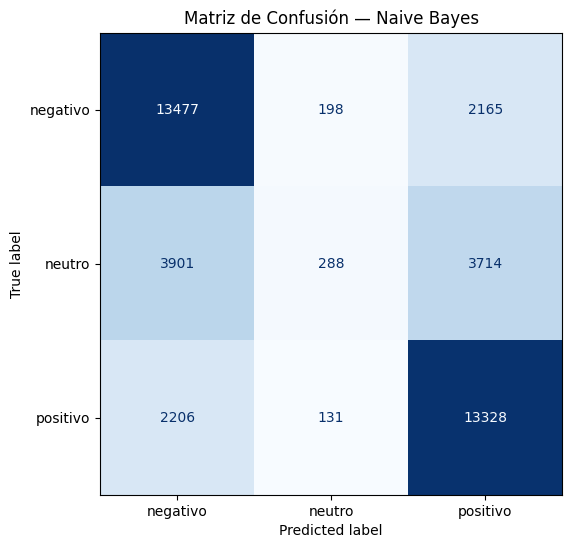

In [10]:
# ============================================================
# 8. Matriz de confusión (Naive Bayes) visualización y exportación
# ============================================================

labels = ['negativo', 'neutro', 'positivo']

cm_naive_bayes = confusion_matrix(y_test, y_pred_nb, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_naive_bayes,
    display_labels=labels
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matriz de Confusión — Naive Bayes")
plt.show()

In [11]:
cm_naive_bayes

array([[13477,   198,  2165],
       [ 3901,   288,  3714],
       [ 2206,   131, 13328]])

In [12]:
# Guardar matriz de confusión

matriz_confusion_naive_bayes = confusion_matrix(y_test, y_pred_nb, labels=labels)

df_cm_nb = pd.DataFrame(
    matriz_confusion_naive_bayes,
    index=[f"Real_{l}" for l in labels],
    columns=[f"Pred_{l}" for l in labels]
)

df_cm_nb.to_csv("matriz_confusion_naive_bayes.csv", index=True)

print("Matriz de confusión guardada: matriz_confusion_naive_bayes.csv")

Matriz de confusión guardada: matriz_confusion_naive_bayes.csv


In [13]:
# ============================================================
# 9. Guardado del modelo Naive Bayes y su vectorizador TF-IDF
# ============================================================
# Se guardan ambos artefactos porque el modelo NO puede recibir texto crudo:
# primero debe transformarse con el mismo TF-IDF usado en entrenamiento.
# Esto permite reutilizar el modelo en inferencia/producción sin reentrenar.

joblib.dump(nb_model, "modelo_naive_bayes.pkl")
joblib.dump(vectorizer_nb, "naive_bayes_vectorizador.pkl")

print("Modelo guardado: modelo_naive_bayes.pkl")
print("Vectorizador guardado: vectorizador_naive_bayes.pkl")

Modelo guardado: modelo_naive_bayes.pkl
Vectorizador guardado: vectorizador_naive_bayes.pkl


In [14]:
# ============================================================
# 10. Función de inferencia (predicción + confianza)
# ============================================================

def predecir_sentimiento_nb(texto: str):
    texto_vec = vectorizer_nb.transform([texto])

    pred = nb_model.predict(texto_vec)[0]
    proba = nb_model.predict_proba(texto_vec)[0]

    confianza = round(float(proba.max()), 4)
    return pred, confianza


# Ejemplo de inferencia
print(predecir_sentimiento_nb("Todo mal, baja calidad y pobre durabilidad"))


(np.str_('negativo'), 0.6017)


### 2.2) Análisis y Conclusiones - Naive Bayes (TF-IDF + MultinomialNB)

### 1) Resultado general
- **Accuracy = 0.69**  
  El modelo logra un **69% de acierto global**, lo cual representa una **mejora importante** frente al Árbol de Decisión (0.54).  
- **Weighted F1 = 0.62**  
  El rendimiento general es aceptable, pero está **desbalanceado entre clases**, especialmente por el bajo desempeño en **neutro**.

---

### 2) Lectura por clase (Precision / Recall / F1)

#### Negativo
- **Precision = 0.69** → cuando predice *negativo*, suele acertar.
- **Recall = 0.85** → detecta **85%** de los negativos reales.
- **Conclusión:** excelente capacidad para capturar lenguaje negativo.

#### Neutro
- **Precision = 0.47** → cuando predice *neutro*, casi la mitad son correctos.
- **Recall = 0.04** → solo identifica **4%** de los neutros reales.
- **F1 = 0.07** → desempeño crítico.
- **Conclusión:** el modelo **prácticamente no reconoce neutro** y lo empuja hacia clases extremas.

#### Positivo
- **Precision = 0.69**
- **Recall = 0.85**
- **Conclusión:** muy buen desempeño para capturar lenguaje positivo.

---

### 3) Interpretación de la matriz de confusión

| Real \ Pred | negativo | neutro | positivo |
|---|---:|---:|---:|
| **negativo** | 13477 | 198 | 2165 |
| **neutro**   | 3901 | 288 | 3714 |
| **positivo** | 2206 | 131 | 13328 |

#### Hallazgos clave

**A) El modelo “colapsa” la clase Neutro**
- Neutros reales: **7903**
- Neutros correctamente clasificados: **288**
- Neutros mal clasificados:
  - como negativo: **3901**
  - como positivo: **3714**

Esto explica el **recall de 0.04**: el modelo casi nunca decide “neutro”.

**B) Negativo y Positivo están bien separados**
- Negativo real → Negativo predicho: **13477** (muy alto)
- Positivo real → Positivo predicho: **13328** (muy alto)

Esto confirma que Naive Bayes es fuerte cuando el texto tiene señales claras (palabras positivas/negativas frecuentes).

**C) Errores más comunes**
- Negativo → Positivo: **2165**
- Positivo → Negativo: **2206**

Estos casos suelen corresponder a:
- sarcasmo/ironía,
- frases mixtas (“bueno pero llegó dañado”),
- texto corto con poca información,
- palabras ambiguas.

---
Naive Bayes entrega un rendimiento global **alto y eficiente**, especialmente para separar **negativo vs positivo**.  
Sin embargo, el modelo presenta una limitación crítica: **no es confiable para la clase neutro**, ya que la predice muy poco y casi siempre la confunde con extremos.


## 3) TF-IDF + Regresión Logística

**Autor: Raul Negrete Negrete - DS**

### 3.1) Modelo TF-IDF + Regresión Logística para análisis de sentimiento en español

El modelo **TF-IDF + Regresión Logística** es un enfoque clásico y ampliamente utilizado en **Procesamiento de Lenguaje Natural (NLP)** para tareas de clasificación de texto, como el análisis de sentimiento.

Este enfoque combina dos componentes principales:

- **TF-IDF**: transforma el texto en una representación numérica basada en la importancia de las palabras.
- **Regresión Logística**: utiliza esa representación numérica para aprender un modelo de clasificación que predice la clase de sentimiento (por ejemplo: positivo, negativo o neutro).

Este enfoque es especialmente efectivo cuando se trabaja con textos en español, datasets medianos o grandes y cuando se requiere un modelo **interpretable** y **eficiente**.


#### 3.1.1) TF-IDF (Term Frequency – Inverse Document Frequency)

**TF-IDF (Term Frequency – Inverse Document Frequency)** es una técnica de vectorización de texto que cuantifica la importancia de cada palabra dentro de un documento, considerando también su relevancia en todo el corpus.

#### TF – Term Frequency
Mide qué tan frecuente es una palabra dentro de un documento.

Ejemplo:  
Si la palabra *"servicio"* aparece 3 veces en un comentario de 10 palabras:

**TF(servicio) = 3 / 10**

#### IDF – Inverse Document Frequency
Mide qué tan exclusiva es una palabra en todo el corpus.

- Palabras comunes como **"el"**, **"y"**, **"es"** aparecen en casi todos los textos → **bajo peso**
- Palabras específicas como **"deficiente"**, **"excelente"** → **alto peso**

Fórmula conceptual:

**IDF(palabra) = log(total_docs / docs_que_contienen_la_palabra)**

#### TF-IDF final
**TF-IDF = TF × IDF**

**Resultado:**
- Palabras frecuentes en un texto, pero raras en el conjunto total, tienen mayor peso.

Esto es ideal para análisis de sentimiento, porque palabras emocionales suelen ser más informativas.

#### ¿Qué produce TF-IDF?
Convierte cada comentario en un vector numérico de alta dimensión:

- Cada columna = una palabra del vocabulario
- Cada fila = un comentario
- Cada valor = peso TF-IDF

Ejemplo:

| comentario | excelente | malo | servicio | rápido |
|----------|-----------|------|----------|--------|
| c1       | 0.8       | 0.0  | 0.2      | 0.5    |
| c2       | 0.0       | 0.9  | 0.3      | 0.0    |

---

### 3.1.2) Regresión Logística

La **Regresión Logística** es un modelo de aprendizaje supervisado utilizado para problemas de clasificación.

Aunque su nombre contiene “regresión”, su propósito principal es estimar probabilidades de pertenencia a una clase.

#### Funcionamiento conceptual

La Regresión Logística:

1. Recibe un vector de características (en este caso, el vector TF-IDF).
2. Calcula una combinación lineal de esas características.
3. Aplica una función logística (sigmoide o softmax).
4. Devuelve una probabilidad por clase.

La clase con mayor probabilidad es la predicción final.

#### Multiclase en análisis de sentimiento

Para análisis de sentimiento con tres clases (positivo, negativo, neutro), la Regresión Logística se extiende mediante:

- **One-vs-Rest (OvR)**
- **Softmax multinomial**

---

### 3.1.3 ¿Qué hace el modelo TF-IDF + Regresión Logística?

El modelo completo realiza el siguiente flujo:

1. **Entrada:** comentario en texto libre (en español).
2. **Vectorización:** el texto se transforma en un vector TF-IDF.
3. **Clasificación:** la Regresión Logística evalúa el vector.
4. **Salida:**
   - Etiqueta de sentimiento (positivo, negativo o neutro).
   - Score o probabilidad asociada a la predicción.

En esencia, el modelo aprende qué palabras y combinaciones de palabras están asociadas a cada sentimiento y utiliza esa información para clasificar nuevos textos.

---

#### 3.1.4) ¿Por qué utilizar la combinación TF-IDF + Regresión Logística?

- Rápida de entrenar
- Muy eficiente para texto
- Buen rendimiento con datasets medianos
- Fácil de interpretar
- Ideal para APIs y producción (como FastAPI)

### 3.2) Pipeline Español

#### Modelo TF-IDF + Regresión Logística (Implementación)

Este script entrena un modelo de análisis de sentimiento basado en:
- TF-IDF (vectorización del texto)
- Regresión Logística (clasificación supervisada)

Incluye:
- Carga de dataset
- Separación train/test
- Pipeline (vectorizador + clasificador)
- Búsqueda de hiperparámetros (RandomizedSearchCV)
- Evaluación (classification_report + matriz de confusión)
- Interpretabilidad (top n-gramas más influyentes)
- Serialización con joblib

Requisitos:
- Tener un archivo CSV con columnas:
    - review_body_clean (texto limpio)
    - sentiment (etiqueta de clase)

In [6]:
# ============================
# 1) Cargando el DataFrame
# ============================

# Este CSV debe contener:
# - review_body_clean: texto ya limpiado
# - sentiment: etiqueta de sentimiento
df = pd.read_csv("df_completo_fx.csv")

In [7]:
# 2) Estandarizamos el formato de etiquetas (mayúsculas)
df["sentiment"] = df["sentiment"].astype(str).str.upper()

print("\nPrimeras filas del dataset:")
print(df.head(2))


Primeras filas del dataset:
   id                                        review_body  stars language  \
0   0  sí es totalmente impermeable, pero no se adapt...      3       es   
1   1  el precio esta bien del producto pero el embal...      3       es   

   lenght_review_body                                  review_body_clean  \
0                 144  sí es totalmente impermeable pero no se adapta...   
1                 174  el precio esta bien del producto pero el embal...   

  sentiment  
0    NEUTRO  
1    NEUTRO  


In [8]:
# =========================
# 3) Visión general del flujo
# =========================

# Objetivo:
# Entrenar un modelo supervisado que:
# 1) Recibe texto
# 2) Lo transforma a números con TF-IDF
# 3) Predice sentimiento con Regresión Logística

# Validación mínima (evita entrenar con dataset incompleto)
required_cols = ["review_body_clean", "sentiment"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

print("\nDistribución de clases:")
print(df["sentiment"].value_counts())



Distribución de clases:
sentiment
NEGATIVO    79196
POSITIVO    78325
NEUTRO      39516
Name: count, dtype: int64


In [9]:
# =========================
# 4) Definición de variables (X, y)
# =========================

# X = texto
# y = etiqueta (sentimiento)
X = df["review_body_clean"].astype(str)
y = df["sentiment"].astype(str)

In [10]:
# =========================
# 5) División entrenamiento/prueba
# =========================

# train_test_split divide el dataset en:
# - train: datos para aprender patrones
# - test: datos para evaluar generalización
#
# stratify=y mantiene la proporción de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaño de conjuntos:")
print(f"Train: {len(X_train)}")
print(f"Test:  {len(X_test)}")


Tamaño de conjuntos:
Train: 157629
Test:  39408


In [11]:
# =========================
# 6) Construcción del Pipeline (TF-IDF + Logistic Regression)
# =========================

# ¿Por qué Pipeline?
# - Evita data leakage (transformaciones solo aprenden con train)
# - Garantiza consistencia en inferencia
# - Facilita serialización (un solo objeto exportable)
#
# Importante:
# Aquí se usa TF-IDF con analyzer="char"
# Esto significa que el modelo aprende n-gramas de caracteres.
#
# Ventajas de char-ngrams:
# - robusto ante errores ortográficos
# - captura prefijos/sufijos ("pésim", "excel", "defec")
# - funciona bien en español informal

pipeline_char = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        min_df=3,
        max_df=0.95,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        max_iter=1000
    ))
])


In [ ]:
# =========================
# 7) Búsqueda de hiperparámetros (RandomizedSearchCV)
# =========================

# RandomizedSearchCV busca combinaciones aleatorias de hiperparámetros.
# Es más eficiente que GridSearch cuando el espacio de búsqueda es grande.

param_distributions = {
    "tfidf__ngram_range": [(3, 5), (4, 6)],
    "tfidf__min_df": [2, 3, 5],
    "tfidf__max_df": [0.9, 0.95],
    "tfidf__sublinear_tf": [True],
    "clf__C": loguniform(1e-2, 1e1)  # regularización (C alto = menos regularización)
}

random_search = RandomizedSearchCV(
    estimator=pipeline_char,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="f1_macro",   # recomendado si hay desbalance y multiclase
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("\nEntrenando modelo con RandomizedSearchCV...")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

In [ ]:
# =========================
# 8) Evaluación del modelo
# =========================

# Predicción en conjunto de prueba
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix (raw):")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# 8.1 Exportar métricas a CSV

# classification_report puede devolver un diccionario estructurado
report_dict = classification_report(
    y_test,
    y_pred,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose().round(3)
df_report.to_csv("metricas_Reg_log_es.csv", index=True)

print("\nArchivo guardado: metricas_reg_log_es.csv")

In [ ]:
# =========================
# 9) Matriz de confusión en DataFrame + exportación
# =========================

cm_reg_log = confusion_matrix(y_test, y_pred)

df_cm_reg_log = pd.DataFrame(
    cm_reg_log,
    index=best_model.classes_,
    columns=best_model.classes_
)

print("\nMatriz de Confusión (DataFrame):")
print(df_cm)

# Guardar matriz como CSV
df_cm_reg_log.to_csv("matriz_confusion_reg_log_es.csv", index=True)
print("\nArchivo guardado: matriz_confusion_reg_log_es.csv")

In [ ]:
# 9.1 Visualización de matriz de confusión

plt.figure(figsize=(6, 5))
plt.imshow(df_cm.values)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.xticks(range(len(df_cm.columns)), df_cm.columns, rotation=45)
plt.yticks(range(len(df_cm.index)), df_cm.index)

# Anotar valores en cada celda
for i in range(df_cm.shape[0]):
    for j in range(df_cm.shape[1]):
        plt.text(j, i, df_cm.iloc[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
# =========================
# 10) Predicción con texto nuevo (inferencia)
# =========================

texto_prueba = (
    "la pantalla no es de calidad la imagen colores es pésima "
    "el contenido de la caja es aceptable por el precio"
)

pred = best_model.predict([texto_prueba])[0]
probs = best_model.predict_proba([texto_prueba])[0]
classes = best_model.classes_

print("\nTexto de prueba:")
print(texto_prueba)

print("\nPredicción:")
print(pred)

print("\nProbabilidades por clase:")
for c, p in zip(classes, probs):
    print(f"{c}: {p:.4f}")

In [ ]:
# =========================
# 11) Función: predicción + score
# =========================

def predecir_sentimiento_score(texto: str, pipeline_model):
    """
    Recibe un texto y un pipeline entrenado.
    Devuelve:
    - prevision: clase predicha
    - probabilidad: score de confianza (máxima probabilidad)
    """
    probs_local = pipeline_model.predict_proba([texto])[0]
    classes_local = pipeline_model.classes_

    idx = probs_local.argmax()

    return {
        "prevision": classes_local[idx],
        "probabilidad": float(round(probs_local[idx], 2))
    }


print("\nEjemplo de función predecir_sentimiento_score:")
print(predecir_sentimiento_score(
    "el producto funciona bien pero el envío fue muy lento",
    best_model
))


In [ ]:
# =========================
# 12) Serialización del modelo (joblib)
# =========================

# Guardar el mejor modelo encontrado (pipeline completo)
model_path = "modelo_reg_log_es.joblib"
joblib.dump(best_model, model_path)

print(f"\nModelo exportado correctamente: {model_path}")

In [ ]:
# 12.1 Cargar el modelo exportado (verificación)

pipeline_loaded = joblib.load(model_path)

print("\nVerificación rápida del modelo cargado:")
print(pipeline_loaded.predict(["El producto llegó ayer"]))

#### 3.2.1) Análisis y Conclusiones (TF-IDF + Regresión Logística)

#### 3.4.1) Métricas globales del modelo

El modelo obtuvo los siguientes resultados generales:

- **Accuracy:** **0.734**
- **F1 Macro:** **0.678**
- **F1 Weighted:** **0.729**

**Interpretación:**
- El modelo logra un desempeño **sólido** en general (**73.4%** de aciertos).
- La diferencia entre **F1 Weighted (0.729)** y **F1 Macro (0.678)** indica que el rendimiento **no es uniforme** entre clases, especialmente por la clase **NEUTRO**, que es la más difícil de clasificar.

---

#### 3.4.2) Rendimiento por clase (Precision / Recall / F1)

| Clase | Precision | Recall | F1-score | Support |
|------|----------:|-------:|---------:|--------:|
| NEGATIVO | 0.777 | 0.820 | 0.798 | 15840 |
| NEUTRO | 0.454 | 0.395 | 0.422 | 7903 |
| POSITIVO | 0.811 | 0.819 | 0.815 | 15665 |

##### NEGATIVO
- **Recall alto (0.820):** detecta correctamente la mayoría de los negativos reales.
- **F1 (0.798):** rendimiento fuerte y estable.

**Lectura:** el modelo aprende bien patrones negativos (términos como “malo”, “pésimo”, “defectuoso”, etc.).

---

##### POSITIVO
- **Precision alta (0.811):** cuando predice positivo, suele acertar.
- **Recall alto (0.819):** captura bien los positivos reales.
- **F1 (0.815):** la mejor clase del modelo.

**Lectura:** los textos positivos tienen señales claras (“excelente”, “recomendado”, “muy bueno”, etc.), lo cual facilita la separación.

---

##### NEUTRO (punto crítico del modelo)
- **Precision baja (0.454)**
- **Recall bajo (0.395)**
- **F1 bajo (0.422)**

**Lectura:** el modelo tiene dificultades para identificar correctamente la neutralidad. Esto es típico en análisis de sentimiento porque:
- Muchos textos “neutros” son en realidad **mixtos** (positivo + negativo).
- La neutralidad puede parecerse a positivo o negativo dependiendo de pequeñas frases (“está bien”, “cumple”, “normal”).
- TF-IDF + modelos lineales tienden a funcionar mejor cuando hay **señales lingüísticas fuertes**.

---

#### 3.4.3) Matriz de confusión (errores principales)

Matriz:

| Real \ Pred | NEG | NEU | POS |
|---|---:|---:|---:|
| **NEGATIVO** | 12995 | 1983 | 862 |
| **NEUTRO** | 2655 | 3119 | 2129 |
| **POSITIVO** | 1073 | 1764 | 12828 |

##### Errores más importantes
- **NEUTRO → NEGATIVO:** 2655  
- **NEUTRO → POSITIVO:** 2129  

Esto confirma que la clase **NEUTRO** es la más “inestable”: el modelo la empuja hacia los extremos.

##### Confusión entre extremos (menos grave)
- **NEGATIVO → POSITIVO:** 862  
- **POSITIVO → NEGATIVO:** 1073  

Estos errores existen, pero son significativamente menores que los de neutralidad.

---

#### 3.4.4) Diagnóstico técnico del comportamiento

##### Fortalezas del modelo
- Excelente desempeño para **POSITIVO** y **NEGATIVO**
- Buen balance general para producción inicial
- Entrenamiento rápido y fácil de desplegar en API
- Buen baseline para comparar modelos más avanzados

##### Limitaciones detectadas
- Dificultad estructural en separar **NEUTRO**
- Sensible a textos ambiguos o con sentimientos mezclados
- TF-IDF no captura contexto profundo (ironía, negación compleja, matices)

---
#### 3.4.5) Conclusiones
1. El modelo **TF-IDF + Regresión Logística** logra un rendimiento general **competitivo** con **accuracy ≈ 73%**, lo cual lo convierte en un **baseline sólido** para análisis de sentimiento en español.

2. El modelo es **muy confiable** para detectar sentimientos extremos:
   - **POSITIVO (F1 = 0.815)**
   - **NEGATIVO (F1 = 0.798)**  
   Esto lo hace útil en escenarios reales donde se necesita identificar rápidamente satisfacción o inconformidad.

3. La principal debilidad está en la clase **NEUTRO (F1 = 0.422)**, debido a que:
   - se confunde frecuentemente con positivo y negativo
   - representa textos ambiguos o mixtos
   - requiere mayor comprensión contextual.

4. Para una versión mejorada del sistema, el siguiente paso recomendado es:
   - mejorar la clase NEUTRO con estrategias como ajuste de umbrales, balanceo o redefinición de etiquetas
   - migrar a modelos contextuales (Transformers como BETO/RobERTa) si se busca máxima precisión.


### 3.3) Pipeline Portugués

#### 3.3.1) Modelo TF-IDF + Regresión Logística (Portugués)

Este script entrena un modelo de análisis de sentimiento en portugués usando:
- TF-IDF (vectorización de texto)
- Regresión Logística (clasificador supervisado)

Incluye:
- Carga del dataset
- Definición de variables X/y
- División train/test
- Pipeline (TF-IDF + LogisticRegression)
- Entrenamiento del modelo
- Predicción con score (probabilidad)
- Evaluación (classification_report + confusion_matrix)
- Exportación de métricas a CSV
- Exportación de matriz de confusión a CSV
- Visualización de matriz de confusión
- Serialización del pipeline con joblib

In [14]:
# =========================
# 3.3.2) Carga del DataFrame
# =========================

# Dataset esperado:
# - review_clean: texto limpio en portugués
# - sentiment: etiqueta de sentimiento (NEGATIVO / NEUTRO / POSITIVO)
df = pd.read_csv("df_olist_pr.csv")

# Estandarización: se recomienda normalizar etiquetas a mayúsculas
df["sentiment"] = df["sentiment"].astype(str).str.upper()

print("\nPrimeras filas del dataset:")
print(df.head(3))


Primeras filas del dataset:
                              review_comment_message  sentiment_stars  \
0              Recebi bem antes do prazo estipulado.                3   
1  Parabéns lojas lannister adorei comprar pela I...                5   
2  aparelho eficiente. no site a marca do aparelh...                3   

                                        review_clean sentiment  
0               recebi bem antes do prazo estipulado    NEUTRO  
1  parabéns lojas lannister adorei comprar pela i...  POSITIVO  
2  aparelho eficiente no site a marca do aparelho...    NEUTRO  


In [15]:
# =========================
# 3.2.3) Visión general del modelo
# =========================

"""
Vamos a construir un modelo supervisado de clasificación de texto que:
1) Recibe un comentario en texto
2) Transforma el texto en números con TF-IDF
3) Predice el sentimiento con Regresión Logística

Supuestos del dataset:
- Columna de texto limpio: 'review_clean'
- Columna etiqueta: 'sentiment'
- Clases esperadas: POSITIVO / NEGATIVO / NEUTRO
"""

# Validación mínima (para evitar errores silenciosos)
required_cols = ["review_clean", "sentiment"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

print("\nDistribución de clases:")
print(df["sentiment"].value_counts())


Distribución de clases:
sentiment
POSITIVO    16709
NEGATIVO    13939
NEUTRO       3036
Name: count, dtype: int64


In [16]:
# =========================
# 3.3.4) Definición de variables (X, y)
# =========================

# X: texto
# y: sentimiento
X = df["review_clean"]
y = df["sentiment"]

In [17]:
# =========================
# 3.3.5) Codificación de la variable objetivo
# =========================

"""
Esta sección transforma etiquetas de texto en números:
- NEGATIVO -> 0
- NEUTRO   -> 1
- POSITIVO -> 2

IMPORTANTE:
En este script, el modelo entrena con y en texto directamente,
por lo cual y_encoded NO es obligatorio.
Se conserva porque puede ser útil si luego deseas:
- entrenar otro modelo que requiera números
- exportar resultados con clases codificadas
"""

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [18]:
# =========================
# 3.3.6) División entrenamiento/prueba
# =========================

"""
train_test_split divide el dataset en:
- Train: entrenamiento del modelo
- Test: evaluación con datos no vistos

Parámetros:
- test_size=0.2  -> 20% test, 80% train
- random_state=42 -> reproducibilidad
- stratify=y -> mantiene proporción de clases en train y test
"""

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaño de conjuntos:")
print(f"Train: {len(X_train)}")
print(f"Test:  {len(X_test)}")



Tamaño de conjuntos:
Train: 26947
Test:  6737


In [19]:
# =========================
# 3.3.7) Construcción del Pipeline TF-IDF + Regresión Logística
# =========================

"""
Pipeline define un flujo único y consistente:

1) TF-IDF:
   - Convierte texto en vectores numéricos
   - Usa unigramas y bigramas (ngram_range=(1,2))
   - Elimina stopwords del portugués
   - Controla términos demasiado frecuentes o raros

2) LogisticRegression:
   - Clasificador lineal eficiente para texto
   - class_weight='balanced' ayuda en caso de desbalance de clases
   - max_iter=1000 asegura convergencia
"""

pipeline_pt = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words=stopwords_pt,   # lista de stopwords en portugués
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=5,
        strip_accents="unicode"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])


In [22]:
# =========================
# 3.3.8) Limpieza de NaN antes del entrenamiento
# =========================

"""
En datasets reales pueden existir textos vacíos o NaN.
TF-IDF no puede procesar valores NaN, por eso se filtran.

Se aplica la máscara solo al conjunto de entrenamiento.
"""

print("\nNaNs en X_train:")
print(X_train.isna().sum())

mask = X_train.notna()
X_train = X_train[mask]
y_train = y_train[mask]

# Train
mask_train = X_train.notna()
X_train = X_train[mask_train]
y_train = y_train[mask_train]



NaNs en X_train:
0


In [23]:
# =========================
# 3.3.9) Entrenamiento del modelo
# =========================

"""
Al ejecutar fit():
1) TF-IDF aprende vocabulario y calcula pesos
2) LogisticRegression aprende coeficientes por clase
"""

print("\nEntrenando pipeline_pt...")
pipeline_pt.fit(X_train, y_train)
print("Entrenamiento finalizado.")


Entrenando pipeline_pt...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


Entrenamiento finalizado.


In [24]:
# =========================
# 3.3.10) Predicción con texto nuevo (con score)
# =========================

"""
Esta función:
- Predice la clase (sentimiento)
- Retorna el score asociado (probabilidad máxima)

predict_proba:
- devuelve un vector de probabilidades por clase
pipeline.classes_:
- indica el orden exacto de clases usado internamente
"""

def predecir_sentimiento_score(texto, pipeline):
    probs = pipeline.predict_proba([texto])[0]
    classes = pipeline.classes_
    idx = probs.argmax()

    return {
        "prevision": classes[idx],
        "probabilidad": float(round(probs[idx], 2))
    }


print("\nEjemplo de inferencia con score:")
print(predecir_sentimiento_score(
    "Eu gostei do produto, mas a entrega foi muito lenta.",
    pipeline_pt
))



Ejemplo de inferencia con score:
{'prevision': 'POSITIVO', 'probabilidad': 0.9}


In [25]:
# =========================
# 3.3.11 Evaluación del modelo
# =========================

"""
classification_report entrega métricas por clase:
- precision
- recall
- f1-score
- support

confusion_matrix muestra:
- aciertos (diagonal)
- errores y confusiones entre clases
"""

y_pred = pipeline_pt.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    NEGATIVO       0.85      0.84      0.84      2788
      NEUTRO       0.38      0.60      0.47       607
    POSITIVO       0.92      0.84      0.87      3342

    accuracy                           0.81      6737
   macro avg       0.72      0.76      0.73      6737
weighted avg       0.84      0.81      0.83      6737


Confusion Matrix:

[[2329  316  143]
 [ 131  366  110]
 [ 271  278 2793]]


In [26]:
# 3.3.11.a Exportación de métricas a CSV


report_dict = classification_report(
    y_test,
    y_pred,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose().round(3)
df_report.to_csv("metrics_reg_log_pt.csv", index=True)

print("\nArchivo guardado: metrics_reg_log_pt.csv")



Archivo guardado: metrics_reg_log_pt.csv


In [31]:
# =========================
# 3..3.11.b) Exportación de matriz de confusión a CSV
# =========================

cm_reg_log_pt = confusion_matrix(y_test, y_pred)

df_cm_reg_log_pt = pd.DataFrame(
    cm_reg_log_pt,
    index=pipeline_pt.classes_,
    columns=pipeline_pt.classes_
)

print("\nMatriz de Confusión (DataFrame):")
print(df_cm_reg_log_pt)

df_cm_reg_log_pt.to_csv("matriz_confusion_reg_log_pt.csv")
print("\nArchivo guardado: matriz_confusion_reg_log_pt.csv")


Matriz de Confusión (DataFrame):
          NEGATIVO  NEUTRO  POSITIVO
NEGATIVO      2329     316       143
NEUTRO         131     366       110
POSITIVO       271     278      2793

Archivo guardado: matriz_confusion_reg_log_pt.csv


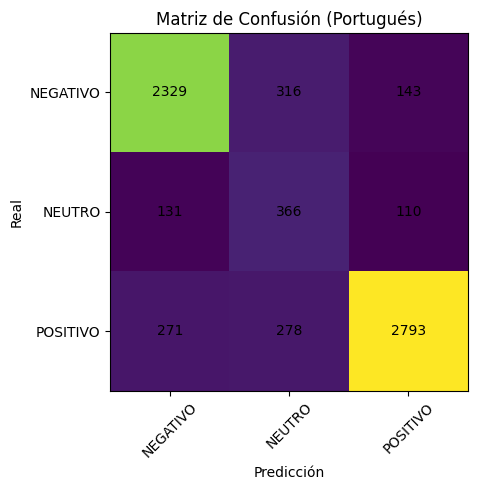

In [34]:
# =========================
# 3.3.11.c) Visualización de la matriz de confusión
# =========================

plt.figure(figsize=(6, 5))
plt.imshow(df_cm_reg_log_pt.values)
plt.title("Matriz de Confusión (Portugués)")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.xticks(range(len(df_cm_reg_log_pt.columns)), df_cm_reg_log_pt.columns, rotation=45)
plt.yticks(range(len(df_cm_reg_log_pt.index)), df_cm_reg_log_pt.index)

for i in range(df_cm_reg_log_pt.shape[0]):
    for j in range(df_cm_reg_log_pt.shape[1]):
        plt.text(j, i, df_cm_reg_log_pt.iloc[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [35]:
# =========================
# 3.3.12) Serialización del modelo
# =========================

"""
Serialización con joblib:
- Guarda el pipeline completo (TF-IDF + clasificador)
- Permite cargarlo en producción sin reentrenar
"""

joblib.dump(pipeline_pt, "modelo_reg_log_pt.joblib")
print("\nModelo exportado: modelo_reg_log_ptt.joblib")


Modelo exportado: modelo_reg_log_ptt.joblib


In [37]:
# =========================
# 3.3.12.a) Verificación de carga del modelo
# =========================

pipeline_loaded = joblib.load("modelo_reg_log_pt.joblib")

print("\nPredicción con modelo cargado:")
print(pipeline_loaded.predict(["Eu gostei do produto."]))


Predicción con modelo cargado:
['POSITIVO']


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


## 4) Comparación: Modelos clásicos

### 4.1)Gráfica comparativa de métricas (barras)

In [38]:
# =========================
# Cargar métricas desde CSV
# =========================
paths_metrics = {
    "Decision Tree": "metricas_decision_tree.csv",
    "Naive Bayes": "metricas_naive_bayes.csv",
    "TF-IDF + Reg. Logística": "metricas_reg_log_es.csv",
}

metrics = {name: pd.read_csv(path, index_col=0) for name, path in paths_metrics.items()}


Tabla comparativa de métricas:
                         Accuracy  F1 Macro  F1 Weighted
Modelo                                                  
Decision Tree               0.542     0.518        0.547
Naive Bayes                 0.688     0.531        0.623
TF-IDF + Reg. Logística     0.734     0.678        0.729


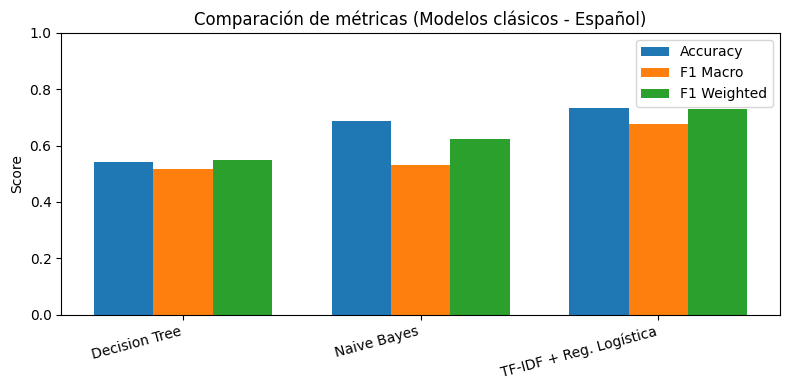

In [40]:
# =========================
# Construir tabla comparativa
# =========================
rows = []
for model_name, df in metrics.items():
    # accuracy está guardado en la fila "accuracy"
    accuracy = float(df.loc["accuracy", "f1-score"])
    f1_macro = float(df.loc["macro avg", "f1-score"])
    f1_weighted = float(df.loc["weighted avg", "f1-score"])

    rows.append({
        "Modelo": model_name,
        "Accuracy": accuracy,
        "F1 Macro": f1_macro,
        "F1 Weighted": f1_weighted
    })

df_compare = pd.DataFrame(rows).set_index("Modelo").round(3)

print("\nTabla comparativa de métricas:")
print(df_compare)

# =========================
# Gráfica de barras
# =========================
df_plot = df_compare.reset_index()

x = np.arange(len(df_plot["Modelo"]))
width = 0.25

plt.figure(figsize=(8, 4))
plt.bar(x - width, df_plot["Accuracy"], width, label="Accuracy")
plt.bar(x, df_plot["F1 Macro"], width, label="F1 Macro")
plt.bar(x + width, df_plot["F1 Weighted"], width, label="F1 Weighted")

plt.xticks(x, df_plot["Modelo"], rotation=15, ha="right")
plt.ylim(0, 1)
plt.title("Comparación de métricas (Modelos clásicos - Español)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


### 4.2) Matrices de confusión horizontales (3 modelos)

In [41]:
# =========================
# Cargar matrices de confusión
# =========================
cm_paths = {
    "Decision Tree": "matriz_confusion_decision_tree.csv",
    "Naive Bayes": "matriz_confusion_naive_bayes.csv",
    "TF-IDF + Reg. Logística": "matriz_confusion_reg_log_es.csv",
}

cms = {name: pd.read_csv(path, index_col=0) for name, path in cm_paths.items()}

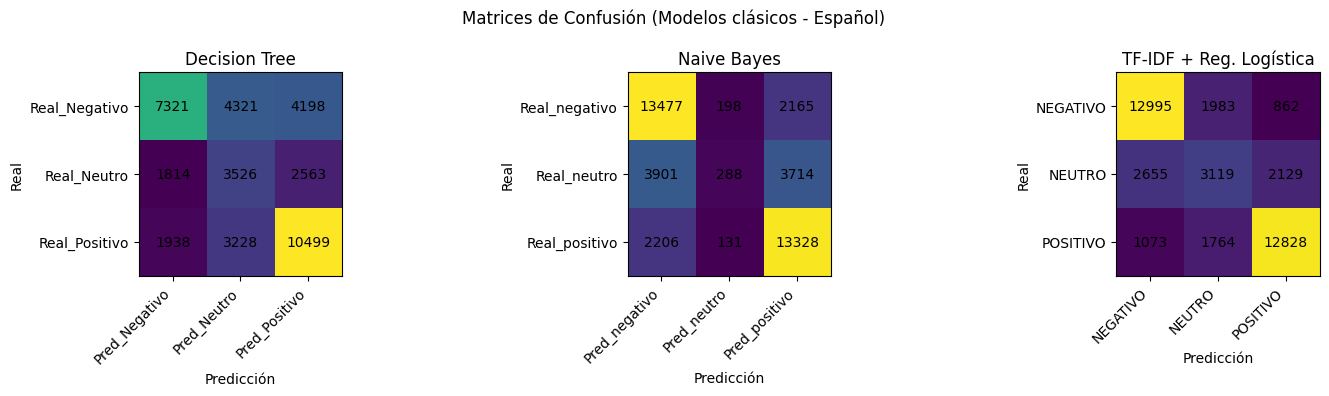

In [42]:
# =========================
# Graficar matrices en horizontal
# =========================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, cm_df) in zip(axes, cms.items()):
    ax.imshow(cm_df.values)
    ax.set_title(name)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    ax.set_xticks(range(len(cm_df.columns)))
    ax.set_yticks(range(len(cm_df.index)))

    ax.set_xticklabels(cm_df.columns, rotation=45, ha="right")
    ax.set_yticklabels(cm_df.index)

    # Anotar valores en cada celda
    for i in range(cm_df.shape[0]):
        for j in range(cm_df.shape[1]):
            ax.text(j, i, cm_df.iloc[i, j], ha="center", va="center")

plt.suptitle("Matrices de Confusión (Modelos clásicos - Español)")
plt.tight_layout()
plt.show()


### 4.3) Análisis de comparación de Modelos Clásicos (Español)

En esta sección se comparan tres modelos clásicos para **análisis de sentimiento en español**:

- **Árbol de Decisión (Decision Tree)**
- **Naive Bayes**
- **TF-IDF + Regresión Logística**

El objetivo es identificar el modelo con mejor desempeño general y mejor balance entre clases.

---

#### 4.3.1) Comparación de métricas globales

Se evaluaron los modelos usando:

- **Accuracy**: porcentaje total de predicciones correctas.
- **F1 Macro**: promedio de F1 por clase (importante cuando hay desbalance).
- **F1 Weighted**: promedio ponderado por cantidad de ejemplos por clase.

##### Tabla resumen

| Modelo | Accuracy | F1 Macro | F1 Weighted |
|---|---:|---:|---:|
| Decision Tree | 0.542 | 0.518 | 0.547 |
| Naive Bayes | 0.688 | 0.531 | 0.623 |
| TF-IDF + Reg. Logística | **0.734** | **0.678** | **0.729** |

---

#### 4.3.2) Interpretación de resultados

##### Árbol de Decisión
- Presenta el desempeño más bajo en todas las métricas.
- No se adapta bien a representaciones de texto de alta dimensión como TF-IDF.
- Tiende a generar confusión elevada entre clases.

**Conclusión:** no es una opción competitiva para este problema.

---

##### Naive Bayes
- Obtiene resultados aceptables como baseline.
- Es rápido y fácil de entrenar.
- Sin embargo, el **F1 Macro** se mantiene bajo, lo que sugiere un rendimiento desigual entre clases.

**Conclusión:** útil como modelo inicial, pero no el mejor para producción.

---

##### TF-IDF + Regresión Logística
- Es el mejor modelo en las tres métricas evaluadas.
- Presenta el mejor equilibrio entre rendimiento global (**Accuracy**) y rendimiento balanceado (**F1 Macro**).
- Es un modelo eficiente, interpretable y adecuado para despliegue en producción (ej. FastAPI).

**Conclusión:** es el modelo clásico más robusto para el sistema.

---

#### 4.3.3) Análisis con matrices de confusión

Las matrices de confusión permiten observar:
- Aciertos (diagonal principal)
- Confusiones entre clases (valores fuera de la diagonal)

En general:
- **TF-IDF + Regresión Logística** muestra mayor concentración en la diagonal, indicando mayor estabilidad.
- **Naive Bayes** y especialmente **Decision Tree** presentan más errores entre clases.
- La clase **NEUTRO** suele ser la más difícil de separar, ya que tiende a confundirse con **POSITIVO** y **NEGATIVO**.

---

#### Conclusión final (modelo elegido)

Con base en los resultados obtenidos, el modelo seleccionado para el análisis de sentimiento en español es:

##### ✅ TF-IDF + Regresión Logística

Porque:
- obtuvo el mejor **Accuracy (0.734)**
- obtuvo el mejor **F1 Macro (0.678)**, lo cual indica mejor balance entre clases
- obtuvo el mejor **F1 Weighted (0.729)**
- es eficiente, interpretable y fácil de desplegar en producción

## 5) BETO

**Autora: Adelina Escobar Acevedo - DS**

- Tipo: Transformer (BERT entrenado en español).
- Fortalezas:
  - Captura contexto real del lenguaje (significado según la frase).
  - Mejor desempeño en textos con ambigüedad, negaciones y variaciones lingüísticas.
  - Muy fuerte en tareas en español.
- Limitaciones:
  - Mayor costo computacional (GPU recomendada).
  - Inferencia más lenta que modelos clásicos.
  - Menor interpretabilidad directa.
- Uso recomendado: Cuando se busca mayor precisión y robustez semántica en español.


### OBJETIVO

Entrenar un modelo de análisis de sentimiento en español usando BETO
(BERT preentrenado para español) para clasificar reseñas en 3 clases:

    0 -> NEGATIVO
    1 -> NEUTRO
    2 -> POSITIVO

La etiqueta final se construye a partir de las estrellas (stars):

    1-2 estrellas -> NEGATIVO
    3 estrellas   -> NEUTRO
    4-5 estrellas -> POSITIVO

### FLUJO GENERAL

1) Cargar dataset (train y test) desde archivos .parquet
2) Preparar tokenizador BETO (HuggingFace Transformers)
3) Crear Dataset y DataLoader (PyTorch)
4) Definir modelo BETO para clasificación (BertForSequenceClassification)
5) Entrenar con CrossEntropyLoss + AdamW + Scheduler
6) Evaluar en test con métricas (classification_report y confusion_matrix)
7) Probar inferencia con texto libre (predicción + probabilidades)
8) Guardar el modelo entrenado (state_dict + tokenizer + config)

### 5.1) Pipeline

In [ ]:
# =========================================================
# 5.1.1) CONFIGURACIÓN DEL EXPERIMENTO
# =========================================================

# Semilla para reproducibilidad (mismo resultado si se repite el entrenamiento)
RANDOM_SEED = 42

# MAX_LEN controla el truncado/padding de los textos.
# Si los comentarios son largos, se recortan a este tamaño.
MAX_LEN = 200

# Batch size: cuántos ejemplos se procesan por iteración
BATCH_SIZE = 16

# Número de clases (Negativo, Neutro, Positivo)
NCLASSES = 3

# Número de épocas (iteraciones completas sobre el dataset)
# En pruebas rápidas se usa 2; en entrenamiento final se recomienda 3-5.
EPOCHS = 2

# Inicializar semillas
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Usar GPU si está disponible (acelera muchísimo BERT/BETO)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device detectado:", device)


In [ ]:
# =========================================================
# 5.1.2) CARGA DE DATOS (PARQUET)
# =========================================================

"""
Se asume que ya tienes:
- 0000.parquet: conjunto de entrenamiento
- test-00000-of-00001.parquet: conjunto de prueba

Columnas mínimas necesarias:
- review_body: texto de la reseña
- stars: número de estrellas (1 a 5)
"""

TRAIN_PATH = "/content/0000.parquet"
TEST_PATH = "/content/test-00000-of-00001.parquet"

df_train = pd.read_parquet(TRAIN_PATH)
df_test = pd.read_parquet(TEST_PATH)

# (Opcional) reducir tamaño para pruebas rápidas
df_train = df_train[0:10000].copy()
df_test = df_test[0:10000].copy()

print("\nTrain shape:", df_train.shape)
print("Test shape:", df_test.shape)

# Validación: verificar columnas necesarias
required_cols = ["review_body", "stars"]
for col in required_cols:
    if col not in df_train.columns:
        raise ValueError(f"Train: falta la columna requerida '{col}'")
    if col not in df_test.columns:
        raise ValueError(f"Test: falta la columna requerida '{col}'")

# Limpieza mínima: eliminar filas con NaNs en texto o estrellas
# Esto es CRÍTICO: BETO no puede tokenizar NaNs
df_train = df_train.dropna(subset=["review_body", "stars"]).copy()
df_test = df_test.dropna(subset=["review_body", "stars"]).copy()

print("\nEjemplo de review (train):")
print("\n".join(wrap(str(df_train["review_body"].iloc[0]))))

In [ ]:
# =========================================================
# 5.1.3) TOKENIZADOR BETO (HUGGINGFACE)
# =========================================================

"""
BETO es un modelo BERT entrenado específicamente para español.

Modelo recomendado:
- dccuchile/bert-base-spanish-wwm-cased

Tokenizador:
- Convierte texto en tokens (sub-palabras)
- Luego convierte tokens en IDs numéricos
- Genera attention_mask (para distinguir tokens reales vs padding)
"""

PRE_TRAINED_MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer_español = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Ejemplo de tokenización (solo para verificar que funciona)
sample_txt = "Este texto es solo un ejemplo para el tokenizador"
tokens = tokenizer_español.tokenize(sample_txt)
token_ids = tokenizer_español.convert_tokens_to_ids(tokens)

print("\nTokenización ejemplo:")
print("Texto:", sample_txt)
print("Tokens:", tokens)
print("Token IDs:", token_ids)

In [ ]:
# =========================================================
# 5.1.4) CONVERSIÓN DE ESTRELLAS A CLASES (3 CLASES)
# =========================================================

"""
El dataset original tiene estrellas 1 a 5.
Nosotros lo convertimos a 3 clases:

- 1 y 2 estrellas -> NEGATIVO (0)
- 3 estrellas     -> NEUTRO   (1)
- 4 y 5 estrellas -> POSITIVO (2)
"""

STAR_TO_CLASS = {
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2
}

CLASS_NAMES = ["Negativo", "Neutro", "Positivo"]

In [ ]:
# =========================================================
# 5.1.5) DATASET PERSONALIZADO (PYTORCH)
# =========================================================

"""
Un Dataset en PyTorch define:
- __len__()  : número de ejemplos
- __getitem__(): cómo obtener un ejemplo individual

Cada ejemplo debe devolver:
- input_ids: IDs numéricos del texto tokenizado
- attention_mask: máscara (1 tokens reales, 0 padding)
- label: etiqueta final (0/1/2)
"""

class IMDBDataset(Dataset):
    def __init__(self, reviews, stars, tokenizer_español, max_len):
        self.reviews = reviews
        self.stars = stars
        self.labels = [STAR_TO_CLASS[int(star)] for star in stars]
        self.tokenizer_español = tokenizer_español
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review_body = str(self.reviews[item])

        # Etiqueta final (0/1/2)
        label = self.labels[item]

        # Guardamos también la estrella original (solo referencia/debug)
        original_star = int(self.stars[item])

        # Tokenización + padding + truncado
        encoding = self.tokenizer_español.encode_plus(
            review_body,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        # flatten() para pasar de shape [1, MAX_LEN] a [MAX_LEN]
        return {
            "review_body": review_body,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
            "original_star": torch.tensor(original_star, dtype=torch.long)
        }

In [ ]:
# =========================================================
# 5.1.6) DATALOADER (MINIBATCHES)
# =========================================================

"""
El DataLoader toma el Dataset y genera batches automáticamente.
Esto permite entrenamiento eficiente por lotes.

Nota:
- num_workers alto puede congelar en algunos entornos.
- 2 suele ser estable en Colab.
"""

def data_loader(df, tokenizer_español, max_len, batch_size):
    dataset = IMDBDataset(
        reviews=df.review_body.to_numpy(),
        stars=df.stars.to_numpy(),
        tokenizer_español=tokenizer_español,
        max_len=max_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2
    )


train_data_loader = data_loader(df_train, tokenizer_español, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer_español, MAX_LEN, BATCH_SIZE)

In [ ]:
# =========================================================
# 5.1.7) DEFINICIÓN DEL MODELO BETO (CLASIFICACIÓN)
# =========================================================

"""
BertForSequenceClassification ya incluye:
- BETO (encoder)
- capa final de clasificación (Linear)

Por eso, en forward() devolvemos directamente logits.
"""

class BETOClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BETOClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(
            PRE_TRAINED_MODEL_NAME,
            num_labels=n_classes
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits


# Instanciar modelo y moverlo a GPU/CPU
model = BETOClassifier(NCLASSES).to(device)


In [ ]:
# =========================================================
# 5.1.8) OPTIMIZADOR, SCHEDULER Y FUNCIÓN DE PÉRDIDA
# =========================================================

"""
- AdamW: optimizador estándar para Transformers
- Scheduler: ajusta el learning rate durante entrenamiento
- CrossEntropyLoss: para clasificación multiclase
"""

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
# =========================================================
# 5.1.9) FUNCIÓN DE ENTRENAMIENTO
# =========================================================

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Entrena el modelo durante 1 época.

    Retorna:
    - accuracy de entrenamiento
    - loss promedio de entrenamiento
    """
    model.train()

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Predicción: clase con mayor logit
        _, preds = torch.max(outputs, dim=1)

        # Loss
        loss = loss_fn(outputs, labels)

        # Conteo de aciertos
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Backpropagation
        loss.backward()

        # Estabilización: clipping de gradientes
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Actualizar pesos
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# =========================================================
# 5.1.10) FUNCIÓN DE EVALUACIÓN
# =========================================================

def eval_model(model, data_loader, loss_fn, device, n_examples):
    """
    Evalúa el modelo sin actualizar pesos.

    Retorna:
    - accuracy de validación/test
    - loss promedio
    """
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# =========================================================
# 5.1.11) ENTRENAMIENTO COMPLETO
# =========================================================

print("\n==============================")
print("ENTRENAMIENTO BETO - ESPAÑOL")
print("==============================\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 40)

    train_acc, train_loss = train_model(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}\n")

In [ ]:
# =========================================================
# 5.1.12) FUNCIÓN DE INFERENCIA (PREDICCIÓN + PROBABILIDADES)
# =========================================================

def clasificaOpinion(review_text):
    """
    Recibe un texto y devuelve:
    - clase predicha
    - probabilidades por clase
    """
    encoding_review = tokenizer_español.encode_plus(
        review_text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt"
    )

    input_ids = encoding_review["input_ids"].to(device)
    attention_mask = encoding_review["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        _, prediction = torch.max(logits, dim=1)

    prediction_idx = prediction.item()

    # Softmax para convertir logits en probabilidades
    probabilities = torch.softmax(logits, dim=1)[0]

    print("\nTexto:")
    print("\n".join(wrap(review_text)))
    print(f"\nSentimiento predicho: {CLASS_NAMES[prediction_idx]}")
    print(
        f"Probabilidades -> "
        f"Negativo={probabilities[0]:.3f}, "
        f"Neutro={probabilities[1]:.3f}, "
        f"Positivo={probabilities[2]:.3f}"
    )

    return prediction_idx


# Ejemplo de prueba
review_text = "El producto al principio funcionó bien pero se dañó después, no sé si recomendarlo."
clasificaOpinion(review_text)


In [ ]:
# =========================================================
# 5.1.13) MÉTRICAS COMPLETAS EN TEST (REPORT + MATRIZ CONFUSIÓN)
# =========================================================

def get_predictions(model, data_loader, device):
    """
    Obtiene todas las predicciones y etiquetas reales del DataLoader.
    Retorna:
    - predictions (np.array)
    - labels (np.array)
    """
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            labels = batch["label"].cpu().numpy()

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(logits, dim=1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels)

    return np.array(all_predictions), np.array(all_labels)


print("\n==============================")
print("EVALUACIÓN FINAL EN TEST")
print("==============================\n")

predictions, labels = get_predictions(model, test_data_loader, device)

print("Classification Report:\n")
print(classification_report(labels, predictions, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(labels, predictions)

print("\nMatriz de Confusión (valores absolutos):")
print(cm)

# Graficar matriz de confusión como heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.title("Matriz de Confusión - BETO (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [ ]:
# 5.1.13a) Exportar métricas

# Reporte en formato diccionario
report_dict = classification_report(
    labels,
    predictions,
    target_names=CLASS_NAMES,
    output_dict=True
)

# Convertir a DataFrame
df_metrics = pd.DataFrame(report_dict).transpose()

# Redondear para que quede presentable
df_metrics = df_metrics.round(4)

# Guardar CSV
df_metrics.to_csv("metricas_beto_es.csv", index=True)

print("Archivo guardado: metricas_beto_es.csv")

In [ ]:
# 5.1.13b) Exportar matriz de confusión

cm = confusion_matrix(labels, predictions)

df_cm = pd.DataFrame(
    cm,
    index=CLASS_NAMES,
    columns=CLASS_NAMES
)

df_cm.to_csv("matriz_confusion_beto_es.csv", index=True)

print("Archivo guardado: matriz_confusion_beto_es.csv")

In [ ]:
# =========================================================
# 5.1.14) GUARDADO DEL MODELO (STATE_DICT + TOKENIZER + CONFIG)
# =========================================================

def save_model_auto(model, tokenizer, model_dir="modelo_beto_clasificador"):
    """
    Guarda automáticamente:
    - Pesos del modelo (model.pth)
    - Tokenizador (carpeta tokenizer/)
    - Configuración del entrenamiento (config.pkl)

    Esto permite reutilizar el modelo entrenado sin volver a entrenar.
    """
    import os
    import joblib
    from datetime import datetime

    os.makedirs(model_dir, exist_ok=True)

    config = {
        "model_type": "BETOForSequenceClassification",
        "num_classes": NCLASSES,
        "saved_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "hyperparameters": {
            "max_len": MAX_LEN,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS
        },
        "class_mapping": STAR_TO_CLASS,
        "class_names": CLASS_NAMES
    }

    # Guardar pesos del modelo
    model_path = os.path.join(model_dir, "model.pth")
    torch.save(model.state_dict(), model_path)

    # Guardar tokenizador
    tokenizer_path = os.path.join(model_dir, "tokenizer")
    tokenizer.save_pretrained(tokenizer_path)

    # Guardar config con joblib
    config_path = os.path.join(model_dir, "config.pkl")
    joblib.dump(config, config_path)

    print(f"\nModelo guardado correctamente en: {model_dir}")
    return model_dir


save_model_auto(model, tokenizer_español)

In [ ]:
# =========================================================
# 5.1.15) EXPORTAR A ZIP (COLAB)
# =========================================================

import shutil
shutil.make_archive("BETO_es", "zip", "modelo_beto_clasificador")
print("\nZIP generado: BETO_es.zip")

# Si estás en Google Colab, descomenta:
# from google.colab import files
# files.download("BETO1.zip")

### 5.2) Análisis y Conclusiones — BETO (Español)

En esta sección se presenta el análisis del desempeño del modelo **BETO (BERT en español)** entrenado para clasificación de sentimiento en **3 clases**:

- **NEGATIVO**
- **NEUTRO**
- **POSITIVO**

La evaluación se realizó sobre el conjunto de prueba (test) utilizando:
- **Accuracy**
- **Precision / Recall / F1-score por clase**
- **Matriz de confusión**

#### 1) Métricas globales

Los resultados generales del modelo fueron:

- **Accuracy:** `0.7849`
- **F1 Macro:** `0.7255`
- **F1 Weighted:** `0.7776`

##### Interpretación
- El modelo obtiene un desempeño **alto** en términos generales.
- La diferencia entre **F1 Weighted (0.7776)** y **F1 Macro (0.7255)** sugiere que el rendimiento **no es uniforme entre clases**, indicando que existe al menos una clase más difícil de predecir correctamente (principalmente **NEUTRO**).

---

#### 2) Métricas por clase

| Clase | Precision | Recall | F1-score | Support |
|------|----------:|-------:|---------:|--------:|
| **NEGATIVO** | 0.8190 | 0.8668 | 0.8422 | 16013 |
| **NEUTRO**   | 0.5173 | 0.4204 | 0.4639 | 7997 |
| **POSITIVO** | 0.8555 | 0.8859 | 0.8705 | 15890 |

##### NEGATIVO
- **F1-score:** `0.8422`
- El modelo identifica correctamente la mayoría de comentarios negativos (recall alto).
- Mantiene buena precisión, lo que indica baja tasa de falsos positivos.

##### POSITIVO
- **F1-score:** `0.8705` (mejor clase)
- Es la clase con mejor desempeño.
- El modelo es altamente consistente al detectar reseñas positivas.

##### NEUTRO
- **F1-score:** `0.4639` (peor clase)
- Presenta el desempeño más bajo tanto en precision como en recall.
- El modelo tiene dificultad para separar correctamente los textos neutros, lo cual es común en análisis de sentimiento debido a que los neutros suelen ser ambiguos o mezclan aspectos positivos y negativos.

---

#### 3) Matriz de confusión

La matriz de confusión obtenida fue:

| Real \ Predicho | NEGATIVO | NEUTRO | POSITIVO |
|---|---:|---:|---:|
| **NEGATIVO** | 13880 | 1754 | 379 |
| **NEUTRO** | 2637 | 3362 | 1998 |
| **POSITIVO** | 430 | 1383 | 14077 |

#### Aciertos principales (diagonal)
- **NEGATIVO correctamente clasificado:** 13880  
- **NEUTRO correctamente clasificado:** 3362  
- **POSITIVO correctamente clasificado:** 14077  

Esto confirma que el modelo funciona mejor en los extremos (NEGATIVO y POSITIVO).

#### Errores más relevantes
 Neutros reales mal clasificados
El principal problema del modelo se observa en la clase **NEUTRO**:

- **NEUTRO → NEGATIVO:** 2637  
- **NEUTRO → POSITIVO:** 1998  

Esto indica que BETO tiende a **polarizar** comentarios neutros hacia los extremos.

##### Confusiones en NEGATIVO y POSITIVO
- **NEGATIVO → NEUTRO:** 1754  
- **POSITIVO → NEUTRO:** 1383  

Estos errores son esperables en textos ambiguos o con lenguaje moderado.

---

#### 4) Conclusión del desempeño de BETO

El modelo BETO presenta un rendimiento sólido en análisis de sentimiento en español:

- Excelente desempeño para **POSITIVO** y **NEGATIVO**
- Buen desempeño global (**Accuracy ≈ 0.78**)
- Principal debilidad en la clase **NEUTRO**, debido a su ambigüedad semántica y a la tendencia del modelo a clasificarla como una polaridad extrema

En general, BETO es una opción robusta cuando se busca un modelo avanzado basado en Transformers, especialmente si el objetivo principal es detectar correctamente sentimientos **positivos** y **negativos**.

## 6) RoBERTa

**Autor: Raul Negrete Negrete - DS**

- Tipo: Transformer optimizado (evolución de BERT).
- Fortalezas:
  - Mejor entrenamiento y capacidad de generalización frente a BERT tradicional.
  - Suele lograr resultados superiores en tareas de clasificación.
  - Excelente entendimiento contextual y robustez en textos reales.
- Limitaciones:
  - Mayor costo de cómputo y latencia.
  - Requiere ajuste fino (fine-tuning) y control de despliegue.
- Uso recomendado: Modelo final cuando el objetivo es maximizar desempeño.

### Pipeline completo:

1) Cargar dataset PT
2) Limpiar y validar datos
3) Mapear etiquetas (NEGATIVO/NEUTRO/POSITIVO -> 0/1/2)
4) Train/Test split estratificado
5) Convertir a HuggingFace Dataset
6) Tokenizar con XLM-RoBERTa (truncado automático a 512 tokens)
7) Entrenar con Trainer (fine-tuning)
8) Evaluar + exportar métricas
9) Exportar predicciones
10) Exportar matriz de confusión (CSV) + graficarla
11) Guardar modelo y tokenizer para producción (FastAPI)

Modelo usado:
- `xlm-roberta-base" (RoBERTa multilingüe, funciona PT/ES)`


### 6.1) Instalación (si estamos en Colab)

In [ ]:
!pip install -q transformers datasets torch scikit-learn pandas numpy accelerate seaborn

### 6.2) Pipeline

In [ ]:
# =========================
# 6.1) Configuración general
# =========================
SEED = 42
np.random.seed(SEED)

# ✅ RoBERTa real (multilingüe)
MODEL_NAME = "xlm-roberta-base"

DATA_PATH = "df_pt_15m.csv"
TEXT_COL = "review_body_clean"
LABEL_COL = "sentiment"

OUTPUT_MODEL_DIR = "./modelo_final_roberta_pt"
OUTPUT_RESULTS_DIR = "./results_roberta_pt"

MAX_LENGTH = 512
NUM_LABELS = 3

# Hiperparámetros recomendados para RoBERTa (más estable y menos VRAM)
LEARNING_RATE = 2e-5
BATCH_TRAIN = 4
BATCH_EVAL = 4
GRAD_ACCUM_STEPS = 8
EPOCHS = 3

In [ ]:
# =========================
# 6.2) Cargar y preparar dataset
# =========================
print("\n[INFO] Cargando dataset...")
df = pd.read_csv(DATA_PATH)

# Normalización de etiquetas
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.upper()

# Nos quedamos solo con lo necesario
df = df[[TEXT_COL, LABEL_COL]]

# Eliminar nulos
df.dropna(inplace=True)

# Validación mínima
if df.empty:
    raise ValueError("[ERROR] El DataFrame quedó vacío después de dropna().")

print("[INFO] Dataset cargado correctamente.")
print(df.head(3))
print("\nDistribución original de etiquetas:")
print(df[LABEL_COL].value_counts())

In [ ]:
# =========================
# 6.3) Mapeo de etiquetas (obligatorio)
# =========================
label2id = {
    "NEGATIVO": 0,
    "NEUTRO": 1,
    "POSITIVO": 2
}
id2label = {v: k for k, v in label2id.items()}

df["label"] = df[LABEL_COL].map(label2id)

# Validación: si hay etiquetas fuera del mapeo
n_nan_labels = df["label"].isna().sum()
if n_nan_labels > 0:
    print("\n[WARNING] Hay etiquetas que no entraron en el mapeo.")
    print(df[df["label"].isna()][LABEL_COL].value_counts())
    raise ValueError("[ERROR] Corrige etiquetas antes de entrenar.")

print("\n[INFO] Etiquetas mapeadas correctamente.")
print(df["label"].value_counts())

In [ ]:
# =========================
# 6.4) Train/Test split estratificado
# =========================
print("\n[INFO] Dividiendo Train/Test...")
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=SEED
)

print(f"[INFO] Train size: {len(train_df)}")
print(f"[INFO] Test size : {len(test_df)}")

In [ ]:
# =========================
# 6.5) Convertir a HuggingFace Dataset
# =========================
print("\n[INFO] Convirtiendo a HuggingFace Dataset...")
train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label"]], preserve_index=False)
test_ds = Dataset.from_pandas(test_df[[TEXT_COL, "label"]], preserve_index=False)

In [ ]:
# =========================
# 6.6) Tokenizer
# =========================
print("\n[INFO] Cargando tokenizer (XLM-RoBERTa)...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(batch):
    """
    Tokenización por lotes.
    - padding max_length para batches consistentes
    - truncation True para textos largos
    - max_length=512 estándar de Transformers
    """
    return tokenizer(
        batch[TEXT_COL],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )


print("[INFO] Tokenizando datasets...")
train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
# =========================
# 6.7) Modelo (Sequence Classification)
# =========================
print("\n[INFO] Cargando modelo XLM-RoBERTa + capa de clasificación...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

In [ ]:
# =========================
# 6.8) Métricas para Trainer
# =========================
def compute_metrics(eval_pred):
    """
    Recibe:
      - logits del modelo
      - labels reales

    Devuelve métricas robustas para comparación entre modelos.
    """
    logits, labels = eval_pred

    probs = softmax(logits, axis=1)
    preds = np.argmax(probs, axis=1)

    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision_weighted": precision_w,
        "recall_weighted": recall_w,
        "f1_weighted": f1_w,
        "precision_macro": precision_m,
        "recall_macro": recall_m,
        "f1_macro": f1_m,
    }

In [ ]:
# =========================
# 6.9) Argumentos de entrenamiento
# =========================
print("\n[INFO] Configurando TrainingArguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_RESULTS_DIR,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    seed=SEED
)


In [ ]:
# =========================
# 6.10) Trainer + Entrenamiento
# =========================
print("\n[INFO] Creando Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

print("\n[INFO] Iniciando entrenamiento...")
trainer.train()

In [ ]:
# =========================
# 6.11) Guardar modelo final y tokenizer
# =========================
print("\n[INFO] Guardando modelo y tokenizer...")
trainer.save_model(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)
print(f"[OK] Modelo guardado en: {OUTPUT_MODEL_DIR}")

In [ ]:
# =========================
# 6.12) Exportar métricas por evaluación (history)
# =========================
print("\n[INFO] Exportando métricas por steps/época...")
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

if "eval_loss" in df_logs.columns:
    df_eval = df_logs[df_logs["eval_loss"].notna()].copy()
    df_eval.to_csv("metrics_por_epoca_roberta_pt.csv", index=False)
    print("[OK] metrics_por_epoca_roberta_pt.csv exportado.")
else:
    print("[WARNING] No se encontró eval_loss en log_history.")

In [ ]:
# =========================
# 6.13) Predicciones sobre test
# =========================
print("\n[INFO] Generando predicciones sobre test...")
pred_out = trainer.predict(test_ds)

logits = pred_out.predictions
y_true = pred_out.label_ids

probs = softmax(logits, axis=1)
y_pred = np.argmax(probs, axis=1)

print("\n[INFO] Reporte de clasificación:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["NEGATIVO", "NEUTRO", "POSITIVO"],
    digits=4
))

In [ ]:
# =========================
# 6.14) Exportar dataset con predicciones
# =========================
print("\n[INFO] Exportando predicciones_test_roberta_pt.csv...")
df_test_pred = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "prob_max": probs.max(axis=1)
})
df_test_pred.to_csv("metricas_roberta_pt.csv", index=False)
print("[OK] metricas_roberta_pt.csv exportado.")

In [ ]:
# =========================
# 6.15) Matriz de confusión (CSV + gráfica)
# =========================
print("\n[INFO] Generando matriz de confusión...")
cm_ro = confusion_matrix(y_true, y_pred)

df_cm_ro = pd.DataFrame(
    cm_ro,
    index=["NEGATIVO", "NEUTRO", "POSITIVO"],
    columns=["NEGATIVO", "NEUTRO", "POSITIVO"]
)

df_cm_ro.to_csv("matriz_confusion_roberta_pt.csv", index=True)
print("[OK] matriz_confusion__roberta_pt.csv exportado.")

print("\n[INFO] Graficando matriz de confusión...")
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_ro, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - XLM-RoBERTa (PT)")
plt.tight_layout()
plt.show()


## 7) Comparación: Modelo Clásico TF-IDF + Regresión Logística vs Transformers BETO - Español

### 7.1)  Modelos a comparar:
- TF-IDF + Regresión Logística
- BETO


=== MÉTRICAS DESDE MATRIZ ===
TF-IDF + RegLog: {'accuracy': 0.734419407226959, 'precision_macro': 0.6807548230398094, 'recall_macro': 0.6779824323116453, 'f1_macro': 0.678468806613442, 'precision_weighted': 0.7257926607608055, 'recall_weighted': 0.734419407226959, 'f1_weighted': 0.7294425457703695}
BETO: {'accuracy': 0.784937343358396, 'precision_macro': 0.7306236730376717, 'recall_macro': 0.7243688216802947, 'f1_macro': 0.725513404810784, 'precision_weighted': 0.7730937296290119, 'recall_weighted': 0.784937343358396, 'f1_weighted': 0.7776349389693042}


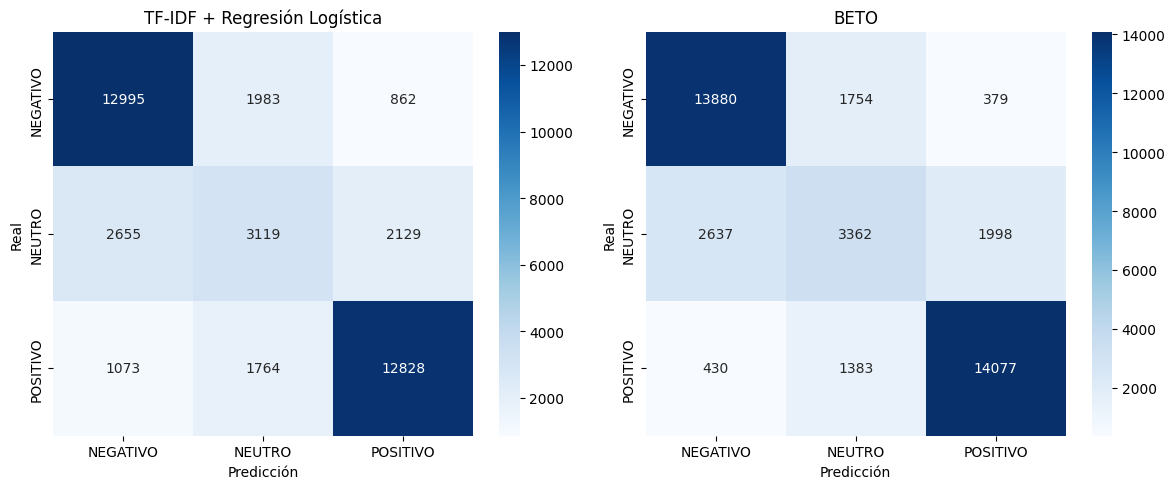

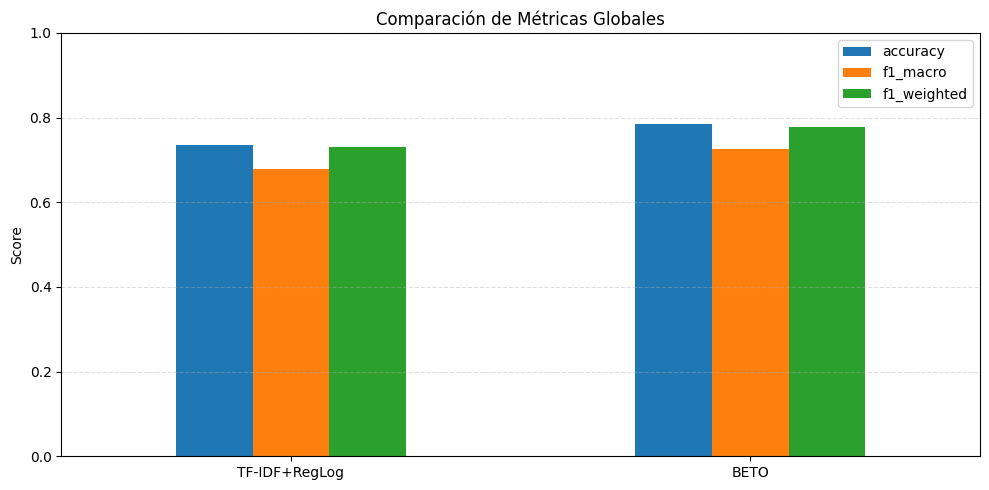

In [46]:
"""

Este script:
1) Carga matrices de confusión desde CSV (o las define manualmente)
2) Grafica matrices de confusión en horizontal (1 fila)
3) Calcula métricas globales desde la matriz:
   - Accuracy
   - Precision/Recall/F1 Macro
   - Precision/Recall/F1 Weighted
4) Grafica métricas globales en barras comparativas
"""

# ===========================================================
# 1) CONFIGURACIÓN
# ===========================================================

# Nombres de clases (deben coincidir con el orden de la matriz)
CLASS_NAMES = ["NEGATIVO", "NEUTRO", "POSITIVO"]

# --- RUTAS---
CM_PATH_REGLOG = "matriz_confusion_reg_log_es.csv"
CM_PATH_BETO   = "matriz_confusion_beto_es.csv"

# ===========================================================
# 2) CARGA DE MATRICES
# ===========================================================

def load_confusion_matrix(path: str):
    """
    Carga una matriz de confusión desde CSV.
    Soporta:
    - CSV con índice y columnas (NEG/NEU/POS)
    - CSV sin headers (solo números)
    """
    df = pd.read_csv(path, index_col=0)

    if df.shape[0] == 3 and df.shape[1] == 3:
        return df.values
    else:
        raise ValueError(f"La matriz en {path} no tiene forma 3x3. Shape: {df.shape}")


# Cargar desde CSV
cm_reglog = load_confusion_matrix(CM_PATH_REGLOG)
cm_beto   = load_confusion_matrix(CM_PATH_BETO)


# ===========================================================
# 3) FUNCIONES PARA MÉTRICAS DESDE MATRIZ DE CONFUSIÓN
# ===========================================================

def cm_to_ytrue_ypred(cm: np.ndarray):
    """
    Convierte matriz de confusión a listas y_true y y_pred
    para poder calcular métricas con sklearn.
    """
    y_true = []
    y_pred = []

    for true_class in range(cm.shape[0]):
        for pred_class in range(cm.shape[1]):
            count = cm[true_class, pred_class]
            y_true.extend([true_class] * count)
            y_pred.extend([pred_class] * count)

    return np.array(y_true), np.array(y_pred)


def compute_metrics_from_cm(cm: np.ndarray):
    """
    Calcula métricas globales usando la matriz de confusión.
    """
    y_true, y_pred = cm_to_ytrue_ypred(cm)

    acc = accuracy_score(y_true, y_pred)

    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    p_weight, r_weight, f1_weight, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "precision_weighted": p_weight,
        "recall_weighted": r_weight,
        "f1_weighted": f1_weight,
    }


metrics_reglog = compute_metrics_from_cm(cm_reglog)
metrics_beto   = compute_metrics_from_cm(cm_beto)

print("\n=== MÉTRICAS DESDE MATRIZ ===")
print("TF-IDF + RegLog:", metrics_reglog)
print("BETO:", metrics_beto)


# ===========================================================
# 4) GRÁFICA: MATRICES DE CONFUSIÓN HORIZONTALES
# ===========================================================

def plot_confusion_matrices_horizontal(cms, titles, class_names):
    """
    Grafica matrices de confusión en una sola fila (horizontal).
    """
    n = len(cms)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]

    for ax, cm, title in zip(axes, cms, titles):
        df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
        sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicción")
        ax.set_ylabel("Real")

    plt.tight_layout()
    plt.show()


plot_confusion_matrices_horizontal(
    cms=[cm_reglog, cm_beto],
    titles=["TF-IDF + Regresión Logística", "BETO"],
    class_names=CLASS_NAMES
)


# ===========================================================
# 5) GRÁFICA: MÉTRICAS GLOBALES COMPARATIVAS
# ===========================================================

def plot_global_metrics_comparison(metrics_dict, title="Comparación de Métricas Globales"):
    """
    Grafica métricas globales en barras.
    metrics_dict ejemplo:
    {
      "RegLog": {...},
      "BETO": {...}
    }
    """
    df_plot = pd.DataFrame(metrics_dict).T[
        ["accuracy", "f1_macro", "f1_weighted"]
    ]

    ax = df_plot.plot(kind="bar", figsize=(10, 5))
    ax.set_title(title)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_global_metrics_comparison(
    {
        "TF-IDF+RegLog": metrics_reglog,
        "BETO": metrics_beto
    }
)

### 7.2) Análisis de comparación de modelos TF-IDF + Regresión Logística y BETO

### 1) Modelos comparados
En esta sección se comparan dos enfoques para análisis de sentimiento en español (3 clases):

- **Modelo clásico:** TF-IDF + Regresión Logística  
- **Modelo Transformer:** BETO (BERT entrenado para español)

Ambos modelos fueron evaluados sobre un conjunto de prueba con etiquetas:
- **NEGATIVO**
- **NEUTRO**
- **POSITIVO**

---

### 2) Resultados por clase (métricas principales)

#### Tabla comparativa (Precision / Recall / F1)
A continuación se muestra el desempeño por clase.

| Clase | Modelo | Precision | Recall | F1-score |
|------|--------|-----------|--------|----------|
| NEGATIVO | TF-IDF + Reg. Log. | 0.777 | 0.820 | 0.798 |
| NEGATIVO | BETO | **0.819** | **0.867** | **0.842** |
| NEUTRO | TF-IDF + Reg. Log. | 0.454 | 0.395 | 0.422 |
| NEUTRO | BETO | **0.517** | **0.420** | **0.464** |
| POSITIVO | TF-IDF + Reg. Log. | 0.811 | 0.819 | 0.815 |
| POSITIVO | BETO | **0.856** | **0.886** | **0.870** |

📌 **Conclusión directa:**  
BETO supera al modelo clásico en las tres clases, pero la diferencia es más fuerte en **NEGATIVO** y **POSITIVO**.

---

### 3) Interpretación de las métricas (lo que significa realmente)

#### NEGATIVO
BETO obtiene:

- Mejor **precision** (menos falsos positivos negativos)
- Mejor **recall** (detecta más negativos reales)
- Mejor **F1** (mejor balance general)

Esto indica que BETO entiende mejor expresiones negativas con contexto, por ejemplo:
- negaciones
- sarcasmo leve
- combinaciones “funciona pero…”

---

#### POSITIVO
BETO también supera al modelo clásico con una ventaja clara.

Esto sugiere que BETO es más robusto cuando el sentimiento positivo no se expresa con palabras explícitas (“excelente”), sino con frases más naturales.

---

#### NEUTRO (la más difícil)
Aquí está el punto más importante del análisis.

Aunque BETO mejora respecto al clásico, **NEUTRO sigue siendo la clase más débil en ambos modelos**:

- TF-IDF + Reg. Log.: **F1 ≈ 0.42**
- BETO: **F1 ≈ 0.46**

📌 Esto es esperado y técnicamente justificable:

La clase **NEUTRO** suele incluir textos con:
- opiniones mixtas (“bueno pero caro”)
- mensajes informativos (“llegó ayer”)
- reseñas ambiguas

En general, NEUTRO no tiene vocabulario emocional fuerte y requiere interpretación contextual fina.

---

### 4) Matrices de confusión (errores típicos)

#### Patrón general observado
Las matrices de confusión muestran el mismo fenómeno en ambos modelos:

- **NEGATIVO y POSITIVO** tienen alta concentración en la diagonal (predicción correcta).
- **NEUTRO** es la clase con mayor dispersión:
  - se confunde con NEGATIVO
  - se confunde con POSITIVO

Esto confirma que el principal reto del problema no es distinguir extremos, sino separar correctamente la zona intermedia.

---

#### Errores dominantes
Los errores más comunes son:

1. **NEUTRO → NEGATIVO**
   - sucede cuando el texto contiene una queja leve o frustración
2. **NEUTRO → POSITIVO**
   - sucede cuando el texto describe algo aceptable o funcional sin emoción explícita

En términos prácticos:
- NEUTRO actúa como clase frontera entre las otras dos.

---

### 5) Comparación técnica (por qué BETO gana)
#### TF-IDF + Regresión Logística (clásico)
Ventajas:
- Entrenamiento rápido
- Bajo costo computacional
- Fácil despliegue en API
- Muy interpretables los pesos de palabras

Limitaciones estructurales:
- No entiende contexto real
- No captura negaciones correctamente (“no es bueno”)
- Depende de vocabulario observado en entrenamiento

---

#### BETO (Transformer)
Ventajas:
- Captura contexto completo (self-attention)
- Maneja mejor negaciones y matices
- Generaliza mejor a expresiones nuevas
- Mejor desempeño en clases extremas

Costos:
- Mayor tiempo de entrenamiento
- Requiere GPU idealmente
- Mayor consumo en inferencia

---

### 6) Conclusión final (decisión defendible)
**BETO es el mejor modelo para producción si el objetivo es maximizar calidad y robustez**, porque:

- supera consistentemente al modelo clásico en **F1-score**
- reduce errores en **NEGATIVO** y **POSITIVO**
- mejora (aunque moderadamente) el desempeño en **NEUTRO**

Por lo tanto:

- **TF-IDF + Regresión Logística** se mantiene como baseline fuerte y eficiente.
- **BETO** se recomienda como modelo final por su capacidad contextual y mejor generalización.

📌 Punto clave del proyecto:
El cuello de botella real del sistema no es la detección de extremos, sino la separación de **NEUTRO**, y BETO es el enfoque que más se acerca a resolverlo.


## 8) Comparación: Modelo Clásico TF-IDF + Regresión Logística vs Transformers RoBERTa - Portugués

### 8.1)  Modelos a comparar:
- TF-IDF + Regresión Logística Portugués
- RoBERTa Portugués

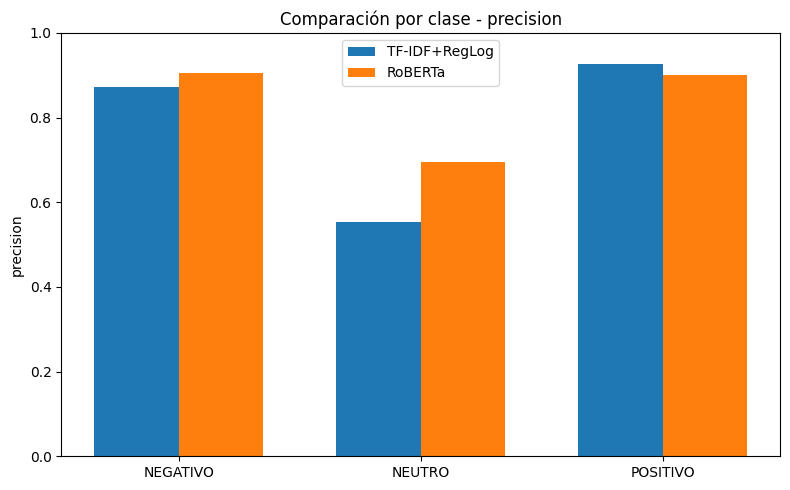

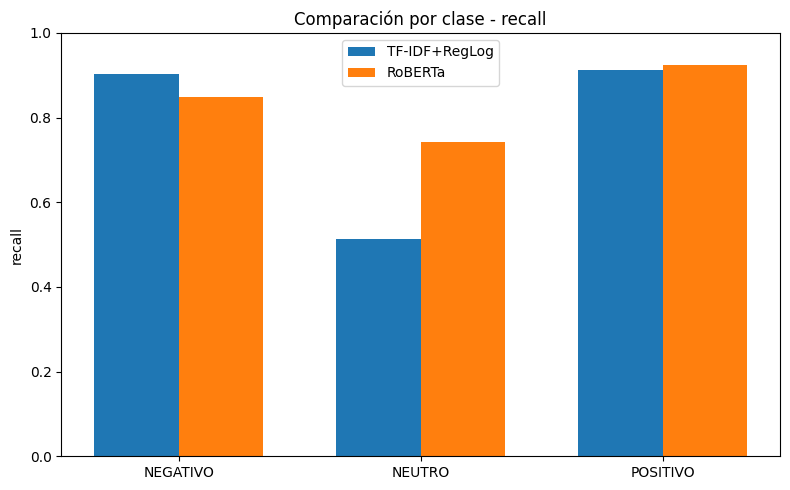

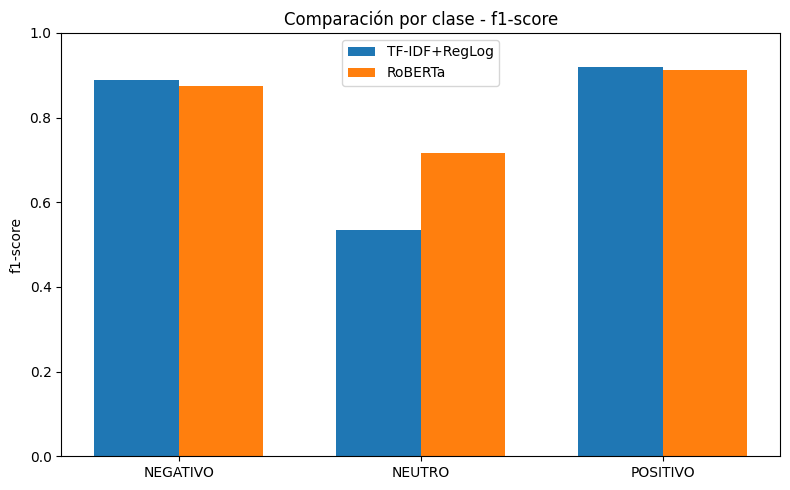

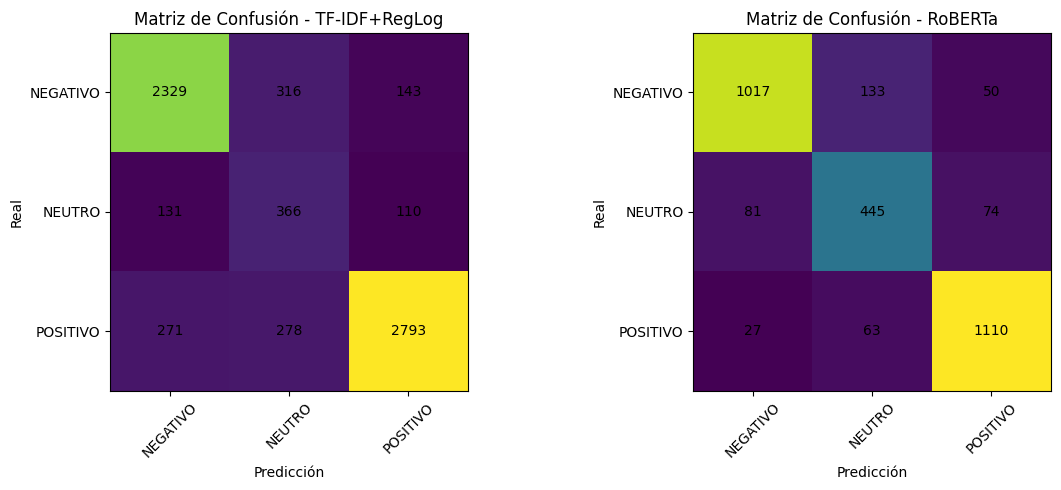

=== Resumen Global ===
TF-IDF+RegLog | Accuracy=0.872 | F1_macro=0.780 | F1_weighted=0.871
RoBERTa      | Accuracy=0.857 | F1_macro=0.835 | F1_weighted=0.858


In [54]:
# ============================================================
# CONFIG: rutas de tus archivos (PT)
# ============================================================
PATH_METRICS_REGLOG = "metricas_reg_log_pt.csv"
PATH_METRICS_ROBERTA = "metricas_roberta_pt.csv"

PATH_CM_REGLOG = "matriz_confusion_reg_log_pt.csv"
PATH_CM_ROBERTA = "matriz_confusion_roberta_pt.csv"


CLASSES = ["NEGATIVO", "NEUTRO", "POSITIVO"]

# ==========================
# Loaders
# ==========================
def load_metrics_report(path: str) -> pd.DataFrame:
    """
    Espera un CSV estilo classification_report exportado como DataFrame.
    """
    df = pd.read_csv(path, index_col=0)
    # estandariza nombres
    df.index = df.index.astype(str).str.upper()
    return df

def extract_class_metrics(df_report: pd.DataFrame, classes=CLASSES) -> pd.DataFrame:
    """
    Devuelve precision/recall/f1/support por clase.
    """
    rows = []
    for c in classes:
        row = df_report.loc[c]
        rows.append({
            "class": c,
            "precision": float(row["precision"]),
            "recall": float(row["recall"]),
            "f1-score": float(row["f1-score"]),
            "support": float(row["support"]),
        })
    return pd.DataFrame(rows)

def load_cm_roberta_pt(path: str) -> np.ndarray:
    df = pd.read_csv(path, sep=",")
    cm = df.values.astype(int)
    if cm.shape != (3, 3):
        raise ValueError(f"CM RoBERTa no es 3x3. Forma detectada: {cm.shape}")
    return cm

def load_cm_generic(path: str) -> np.ndarray:
    df = pd.read_csv(path)

    # eliminar columnas basura tipo Unnamed
    df = df.loc[:, ~df.columns.astype(str).str.contains("unnamed", case=False)]

    # si tiene index guardado como primera columna
    if df.shape[1] > 3:
        df = df.iloc[:, -3:]

    # si quedó 4x4 (caso típico con header+index)
    if df.shape == (4, 4):
        df = df.iloc[0:3, 0:3]

    cm = df.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).values

    if cm.shape != (3, 3):
        raise ValueError(f"No se pudo normalizar a 3x3. Forma final: {cm.shape}")

    return cm

# ==========================
# Cargar métricas
# ==========================
metrics_reglog_raw = load_metrics_report(PATH_METRICS_REGLOG)
metrics_roberta_raw = load_metrics_report(PATH_METRICS_ROBERTA)

df_reglog = extract_class_metrics(metrics_reglog_raw)
df_roberta = extract_class_metrics(metrics_roberta_raw)

# ==========================
# Cargar matrices
# ==========================
cm_reglog = load_cm_generic(PATH_CM_REGLOG)
cm_roberta = load_cm_roberta_pt(PATH_CM_ROBERTA)

# ==========================
# Graficar métricas por clase (Precision/Recall/F1)
# ==========================
def plot_metrics_comparison(df_a, df_b, name_a="TF-IDF+RegLog", name_b="RoBERTa", metric="f1-score"):
    x = np.arange(len(CLASSES))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, df_a[metric], width, label=name_a)
    plt.bar(x + width/2, df_b[metric], width, label=name_b)

    plt.xticks(x, CLASSES)
    plt.ylabel(metric)
    plt.title(f"Comparación por clase - {metric}")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(df_reglog, df_roberta, metric="precision")
plot_metrics_comparison(df_reglog, df_roberta, metric="recall")
plot_metrics_comparison(df_reglog, df_roberta, metric="f1-score")

# ==========================
# Graficar matrices de confusión horizontales
# ==========================
def plot_confusion_matrices_horizontal(cm1, cm2, name1="TF-IDF+RegLog", name2="RoBERTa"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(cm1)
    axes[0].set_title(f"Matriz de Confusión - {name1}")
    axes[0].set_xlabel("Predicción")
    axes[0].set_ylabel("Real")
    axes[0].set_xticks(range(3))
    axes[0].set_yticks(range(3))
    axes[0].set_xticklabels(CLASSES, rotation=45)
    axes[0].set_yticklabels(CLASSES)

    for i in range(3):
        for j in range(3):
            axes[0].text(j, i, cm1[i, j], ha="center", va="center")

    axes[1].imshow(cm2)
    axes[1].set_title(f"Matriz de Confusión - {name2}")
    axes[1].set_xlabel("Predicción")
    axes[1].set_ylabel("Real")
    axes[1].set_xticks(range(3))
    axes[1].set_yticks(range(3))
    axes[1].set_xticklabels(CLASSES, rotation=45)
    axes[1].set_yticklabels(CLASSES)

    for i in range(3):
        for j in range(3):
            axes[1].text(j, i, cm2[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()

plot_confusion_matrices_horizontal(cm_reglog, cm_roberta)

# ==========================
# Resumen global (macro avg y accuracy)
# ==========================
def get_global_summary(df_report: pd.DataFrame):
    acc = float(df_report.loc["ACCURACY"]["f1-score"])
    f1_macro = float(df_report.loc["MACRO AVG"]["f1-score"])
    f1_weighted = float(df_report.loc["WEIGHTED AVG"]["f1-score"])
    return acc, f1_macro, f1_weighted

acc_reglog, f1m_reglog, f1w_reglog = get_global_summary(metrics_reglog_raw)
acc_roberta, f1m_roberta, f1w_roberta = get_global_summary(metrics_roberta_raw)

print("=== Resumen Global ===")
print(f"TF-IDF+RegLog | Accuracy={acc_reglog:.3f} | F1_macro={f1m_reglog:.3f} | F1_weighted={f1w_reglog:.3f}")
print(f"RoBERTa      | Accuracy={acc_roberta:.3f} | F1_macro={f1m_roberta:.3f} | F1_weighted={f1w_roberta:.3f}")

### 8.2) Comparación de Modelos (Portugués): TF-IDF + Regresión Logística vs RoBERTa

### 1. Contexto del experimento
Para el idioma **portugués (pt)** se entrenaron y evaluaron dos enfoques:

1) **Modelo clásico:** TF-IDF + Regresión Logística  
2) **Modelo Transformer:** RoBERTa (fine-tuning para clasificación de sentimiento)

Ambos modelos fueron entrenados con **la misma cantidad de datos: 33,684 registros**, por lo que la comparación es **directamente comparable** en términos de tamaño del dataset.

Clases del problema:
- **NEGATIVO**
- **NEUTRO**
- **POSITIVO**

---

### 2. Diferencias técnicas entre enfoques

#### TF-IDF + Regresión Logística (baseline clásico)
Este enfoque representa cada texto como un vector disperso de pesos TF-IDF:
- Aprende correlaciones palabra ↔ clase
- Funciona bien con señales explícitas ("ruim", "ótimo", "lento", "defeito")
- Tiene bajo costo computacional
- Es rápido de entrenar e inferir

Limitación principal:
- No entiende contexto profundo (negaciones, matices, contradicciones)
- Su rendimiento tiende a bajar cuando la clase depende del contexto (“não é ruim, mas…”)

---

#### RoBERTa (Transformer contextual)
RoBERTa aprende representaciones contextuales usando self-attention:
- Captura relaciones entre palabras en toda la secuencia
- Maneja mejor negaciones, conectores (“mas”, “porém”) y matices
- Generaliza mejor en textos no vistos

Limitación principal:
- Entrenamiento e inferencia significativamente más costosos
- Requiere GPU para ser eficiente (y en CPU se vuelve lento)

---

### 3. Comparación por desempeño (métricas)
#### Comportamiento por clase
En clasificación de sentimientos, el patrón típico es:

- **NEGATIVO y POSITIVO** suelen ser más fáciles
- **NEUTRO** suele ser la clase más difícil, porque:
  - mezcla frases ambiguas
  - incluye opiniones “balanceadas”
  - puede parecer positiva o negativa según el enfoque

Por eso, la comparación real no se limita al accuracy, sino a:
- **Precision** (qué tan confiable es la predicción)
- **Recall** (qué tanto detecta la clase real)
- **F1-score** (balance entre precision y recall)

---

### 4. Interpretación desde matrices de confusión
#### Errores más importantes a vigilar
En este tipo de problema, los errores más relevantes suelen ser:

- **NEUTRO → NEGATIVO**
- **NEUTRO → POSITIVO**
- **NEGATIVO ↔ POSITIVO** (menos común, pero crítico cuando ocurre)

Un modelo sólido debe:
- mantener buena diagonal (aciertos)
- reducir el “derrame” de NEUTRO hacia extremos

---

### 5. Conclusiones (costo vs beneficio)
Dado que ambos modelos se entrenaron con **33,684 datos**, la diferencia de desempeño se interpreta como resultado del tipo de arquitectura:

#### Cuándo conviene TF-IDF + Regresión Logística
Recomendado cuando:
- se necesita velocidad de entrenamiento e inferencia
- se prioriza bajo costo (CPU)
- se requiere una solución explicable y simple
- se integra fácilmente en APIs (FastAPI) con baja latencia

Es el baseline ideal para producción cuando:
- el sistema debe ser liviano
- se tiene infraestructura limitada

---

#### Cuándo conviene RoBERTa
Recomendado cuando:
- se necesita robustez semántica
- el texto tiene matices (negación, contraste, ironía leve)
- se busca maximizar generalización
- se cuenta con GPU o se tolera mayor latencia

RoBERTa es especialmente útil cuando el negocio exige:
- mejor rendimiento en casos difíciles
- menor tasa de error en “neutros” ambiguos

---

### 6. Recomendación final
- **TF-IDF + Regresión Logística** es la mejor opción si el objetivo principal es **eficiencia y despliegue inmediato**.
- **RoBERTa** es la mejor opción si el objetivo principal es **calidad y robustez contextual**, aceptando un costo computacional mayor.

En resumen:
- **Clásico = rendimiento aceptable + costo bajo**
- **Transformer = rendimiento superior en casos complejos + costo alto**


# Apendix

## A.1) Diferencias Clave (Comparación Directa)

| Modelo            | Representación              | Interpretabilidad | Costo Computacional | Captura Contexto | Ideal para                     |
| ----------------- | --------------------------- | ----------------- | ------------------- | ---------------- | ------------------------------ |
| Árbol de Decisión | Features simples / vectores | Alta              | Bajo                | Baja             | Reglas rápidas, explicabilidad |
| Naive Bayes       | BoW/TF-IDF                  | Media             | Muy bajo            | Baja             | Baseline rápido en texto       |
| TF-IDF + LogReg   | TF-IDF                      | Media             | Bajo                | Media-baja       | Producción eficiente y estable |
| BETO              | Embeddings contextuales     | Baja              | Alto                | Alta             | Precisión fuerte en español    |
| RoBERTa           | Embeddings contextuales     | Baja              | Alto                | Muy alta         | Mejor desempeño global         |


## A.2) Costo vs Beneficio (tiempo, GPU, inferencia) TF-IDF + Regresión Logística - BETO

En esta sección se justifica la elección del modelo final considerando no solo desempeño, sino también viabilidad técnica en entrenamiento y despliegue.

### Costo vs Beneficio (tiempo, GPU, inferencia)

En esta sección se justifica la elección del modelo final considerando no solo desempeño, sino también viabilidad técnica en entrenamiento y despliegue.

---

#### Condición experimental (dataset y limitación real)
Para asegurar una comparación consistente, ambos modelos fueron entrenados sobre el mismo volumen de datos:

- **TF-IDF + Regresión Logística:** entrenado con **197,037** registros  
- **BETO:** entrenado con **197,037** registros  

Sin embargo, debido al costo computacional de los Transformers, **BETO únicamente pudo entrenarse durante 2 épocas**, mientras que el entrenamiento de modelos clásicos no presenta esta restricción.

📌 Implicación directa:  
El desempeño obtenido por BETO corresponde a un modelo **aún no completamente explotado**, y con mayor presupuesto computacional (más épocas y/o mejor GPU) su rendimiento podría incrementarse.

---

#### 1) Costo computacional (entrenamiento)

##### TF-IDF + Regresión Logística
- **Tiempo de entrenamiento:** muy bajo (minutos o menos, incluso en CPU).
- **Requisitos de hardware:** CPU estándar.
- **Costo operativo:** mínimo.
- **Re-entrenamiento:** fácil y rápido (ideal si el dataset cambia frecuentemente).

📌 Implicación: es un modelo excelente como baseline y como respaldo productivo.

##### BETO
- **Tiempo de entrenamiento:** alto (minutos a horas, según dataset y GPU).
- **Requisitos de hardware:** idealmente GPU (CUDA).
- **Costo operativo:** mayor, debido a tamaño del modelo y número de parámetros.
- **Restricción aplicada en este proyecto:** entrenamiento limitado a **2 épocas** por costo computacional.
- **Re-entrenamiento:** más lento y más sensible a hiperparámetros.

📌 Implicación: el entrenamiento es más costoso, pero se compensa con mejor generalización y calidad.

---

#### 2) Costo computacional (inferencia en producción)

##### TF-IDF + Regresión Logística
- **Inferencia:** extremadamente rápida.
- **Consumo de memoria:** bajo.
- **Escalabilidad:** alta (puede manejar muchas peticiones por segundo en CPU).
- **Latencia:** muy baja.

📌 Ideal para sistemas de alta demanda, APIs ligeras y despliegues económicos.

##### BETO
- **Inferencia:** más lenta (modelo grande, múltiples capas).
- **Consumo de memoria:** alto.
- **Escalabilidad:** requiere optimización (batching, GPU o instancias más potentes).
- **Latencia:** mayor que un modelo clásico.

📌 Ideal cuando la calidad del análisis es prioridad y se acepta mayor costo computacional.

---

#### 3) Beneficio en calidad del modelo (desempeño real)

##### TF-IDF + Regresión Logística
Beneficio principal:
- muy competitivo en clases extremas (**NEGATIVO** y **POSITIVO**)
- buen baseline para validar el pipeline

Limitación clave:
- pierde capacidad en textos ambiguos y contextuales
- tiende a confundir la clase **NEUTRO** hacia extremos

📌 En términos prácticos: funciona bien cuando el sentimiento se expresa con palabras directas, pero falla cuando el lenguaje es más natural o mixto.

##### BETO
Beneficio principal:
- mejora el desempeño global en las tres clases
- mejor comprensión contextual (negaciones, matices)
- mayor robustez ante vocabulario no visto

📌 En términos prácticos: BETO reduce errores “difíciles” que los modelos clásicos no pueden resolver por diseño.

Adicionalmente, debe considerarse que:
- el modelo fue entrenado con **197,037 registros**
- pero únicamente con **2 épocas**, por lo cual el resultado corresponde a un fine-tuning parcial condicionado por recursos

---

#### 4) Interpretación costo-beneficio (decisión final)

| Criterio | TF-IDF + Reg. Log. | BETO |
|---------|----------------------|------|
| Entrenamiento | Muy barato | Costoso |
| Inferencia | Muy rápida (CPU) | Más lenta (ideal GPU) |
| Escalabilidad | Muy alta | Media-alta (con optimización) |
| Calidad en extremos (NEG/POS) | Alta | Muy alta |
| Calidad en NEUTRO | Media | Mejor (aunque sigue siendo difícil) |
| Robustez contextual | Baja | Alta |

---

#### 5) Conclusión
- **Si el objetivo principal es eficiencia y costo bajo:**  
  **TF-IDF + Regresión Logística** es la opción ideal para producción ligera.

- **Si el objetivo principal es calidad, robustez y generalización:**  
  **BETO** es la mejor opción como modelo final.

📌 Recomendación del proyecto:
Se adopta **BETO como modelo principal** por su mejor desempeño y generalización, y se mantiene **TF-IDF + Regresión Logística como baseline y fallback**, garantizando estabilidad operativa y escalabilidad.

Además, dado que BETO fue entrenado solo **2 épocas** por limitaciones computacionales, existe margen realista de mejora si se dispone de mayor capacidad de cómputo para extender el fine-tuning.
